# SWELL HRV Stress Analysis - Kompletna Analiza

## Cel projektu:
Analiza danych SWELL (Stress, Workload, Emotion Load) na podstawie HRV (Heart Rate Variability) dla wykrywania stresu w warunkach pracy biurowej.

## Dataset:
- **Źródło**: `/Users/turfian/Downloads/hrv dataset`
- **Dane surowe**: RRI (R-R Intervals) w `data/raw/rri/` (p1.txt - p25.txt)
- **Dane przetworzone**: `data/final/train.csv` i `test.csv` z featureami HRV
- **Etykiety**: `data/raw/labels/hrv stress labels.xlsx`
- **Warunki**: `no stress`, `interruption`, `time pressure`

## Plan analizy (krok po kroku):

### 1️⃣ Preprocessing
- Segmentacja sygnałów (30s lub 60s)
- Filtracja (basic, nic egzotycznego)
- Normalizacja per-osoba

### 2️⃣ Feature Engineering (mięso analizy)
**HRV:**
- RMSSD ✅ (już jest w danych)
- SDNN ✅ (jako SDRR w danych)
- pNN50 ✅ (już jest w danych)
- LF / HF ✅ (już jest w danych)

### 3️⃣ Modele (klasyczne, solidne)
- Logistic Regression (baseline)
- Random Forest
- XGBoost / GradientBoosting

### 4️⃣ DWA tryby uczenia (to robi wrażenie)
**🔹 Global model:**
- train: wszyscy
- test: wszyscy

**🔹 Personalised model:**
- osobny model per uczestnik
- albo fine-tuning na 1 osobę

### 5️⃣ Interpretacja (tu wygrywasz)
- feature importance
- SHAP values
- wnioski kliniczne

**Stack technologiczny (lekki, stabilny):**
- Python, numpy/pandas, scipy, sklearn, shap, matplotlib/seaborn

## KROK 1: Import bibliotek i konfiguracja


In [45]:
# 🔹 IMPORTS I KONFIGURACJA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

# Signal processing
from scipy import signal
from scipy.signal import butter, filtfilt, find_peaks
from scipy.stats import skew, kurtosis
from scipy.fft import fft, fftfreq

# ML
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# SHAP dla interpretacji
try:
    import shap
    HAS_SHAP = True
except ImportError:
    HAS_SHAP = False
    print("⚠️ SHAP nie jest zainstalowany. Zainstaluj: pip install shap")

# XGBoost (opcjonalnie)
try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print("⚠️ XGBoost nie jest zainstalowany. Zainstaluj: pip install xgboost")

# Konfiguracja
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Biblioteki zaimportowane")
print(f"✅ SHAP dostępny: {HAS_SHAP}")
print(f"✅ XGBoost dostępny: {HAS_XGB}")

# Ścieżki do danych
SWELL_DATA_DIR = Path("/Users/turfian/Downloads/hrv dataset")
TRAIN_CSV = SWELL_DATA_DIR / "data" / "final" / "train.csv"
TEST_CSV = SWELL_DATA_DIR / "data" / "final" / "test.csv"
RRI_DIR = SWELL_DATA_DIR / "data" / "raw" / "rri"
LABELS_FILE = SWELL_DATA_DIR / "data" / "raw" / "labels" / "hrv stress labels.xlsx"

print(f"\n📁 Ścieżki do danych:")
print(f"   Train CSV: {TRAIN_CSV}")
print(f"   Test CSV: {TEST_CSV}")
print(f"   RRI Dir: {RRI_DIR}")
print(f"   Labels: {LABELS_FILE}")


✅ Biblioteki zaimportowane
✅ SHAP dostępny: True
✅ XGBoost dostępny: True

📁 Ścieżki do danych:
   Train CSV: /Users/turfian/Downloads/hrv dataset/data/final/train.csv
   Test CSV: /Users/turfian/Downloads/hrv dataset/data/final/test.csv
   RRI Dir: /Users/turfian/Downloads/hrv dataset/data/raw/rri
   Labels: /Users/turfian/Downloads/hrv dataset/data/raw/labels/hrv stress labels.xlsx


### Eksploracja struktury bazy danych SWELL HRV


In [46]:
# 🔍 DOKŁADNA EKSPLORACJA STRUKTURY BAZY DANYCH SWELL HRV
print("=" * 80)
print("DOKŁADNA ANALIZA STRUKTURY BAZY DANYCH 'hrv dataset'")
print("=" * 80)

base_dir = Path("/Users/turfian/Downloads/hrv dataset")

if not base_dir.exists():
    print(f"\n❌ Katalog nie istnieje: {base_dir}")
    print(f"   Sprawdź ścieżkę!")
else:
    print(f"\n✅ Katalog główny istnieje: {base_dir}")
    
    # 1. Struktura katalogów
    print(f"\n{'='*80}")
    print("📁 STRUKTURA KATALOGÓW:")
    print(f"{'='*80}")
    
    def explore_directory(path, level=0, max_level=3):
        """Rekurencyjnie eksploruje katalog"""
        indent = "  " * level
        items = sorted(path.iterdir())
        
        dirs = [item for item in items if item.is_dir()]
        files = [item for item in items if item.is_file()]
        
        for dir_item in dirs:
            if level < max_level:
                print(f"{indent}📂 {dir_item.name}/")
                explore_directory(dir_item, level+1, max_level)
        
        for file_item in files:
            size = file_item.stat().st_size
            size_mb = size / (1024 * 1024)
            if size_mb > 1:
                print(f"{indent}  📄 {file_item.name} ({size_mb:.2f} MB)")
            else:
                print(f"{indent}  📄 {file_item.name} ({size / 1024:.1f} KB)")
    
    explore_directory(base_dir, max_level=4)
    
    # 2. Sprawdź wszystkie pliki CSV
    print(f"\n{'='*80}")
    print("📊 PLIKI CSV:")
    print(f"{'='*80}")
    
    csv_files = list(base_dir.rglob("*.csv"))
    print(f"\nZnaleziono {len(csv_files)} plików CSV:")
    for csv_file in sorted(csv_files):
        size_mb = csv_file.stat().st_size / (1024 * 1024)
        rel_path = csv_file.relative_to(base_dir)
        print(f"   📄 {rel_path} ({size_mb:.2f} MB)")
        
        # Wczytaj i sprawdź zawartość (pierwsze 3 wiersze)
        try:
            df_sample = pd.read_csv(csv_file, nrows=3)
            print(f"      Shape (sample): {df_sample.shape}")
            print(f"      Kolumny: {list(df_sample.columns)[:8]}...")
            if 'datasetId' in df_sample.columns:
                print(f"      datasetId (unique): {sorted(df_sample['datasetId'].unique())}")
            if 'condition' in df_sample.columns:
                print(f"      condition (unique): {df_sample['condition'].unique()}")
        except Exception as e:
            print(f"      ⚠️ Błąd wczytania: {e}")
    
    # 3. Sprawdź pliki RRI (surowe dane)
    print(f"\n{'='*80}")
    print("📊 PLIKI RRI (SUROWE DANE):")
    print(f"{'='*80}")
    
    rri_dirs = [
        base_dir / "data" / "raw" / "rri",
        base_dir / "hrv dataset" / "data" / "raw" / "rri",
    ]
    
    rri_files_found = []
    for rri_dir in rri_dirs:
        if rri_dir.exists():
            rri_files = sorted(list(rri_dir.glob("p*.txt")))
            print(f"\n📂 Katalog: {rri_dir}")
            print(f"   Znaleziono {len(rri_files)} plików RRI")
            print(f"   Pliki: {[f.name for f in rri_files]}")
            
            # Sprawdź przykładowe pliki
            if len(rri_files) > 0:
                print(f"\n   📊 Przykładowe dane z pierwszych 5 plików:")
                for rri_file in rri_files[:5]:
                    try:
                        df_rri = pd.read_csv(rri_file, sep='\s+', header=None, names=['time', 'rri'], nrows=10)
                        full_lines = sum(1 for _ in open(rri_file))
                        print(f"      {rri_file.name}:")
                        print(f"         Całkowita liczba wierszy: {full_lines}")
                        print(f"         Przykładowe wartości RRI: {df_rri['rri'].head(5).tolist()}")
                        print(f"         RRI range: [{df_rri['rri'].min():.2f}, {df_rri['rri'].max():.2f}] ms")
                    except Exception as e:
                        print(f"      {rri_file.name}: ⚠️ Błąd wczytania - {e}")
                rri_files_found.extend(rri_files)
            break
    
    if not rri_files_found:
        print(f"   ⚠️ Nie znaleziono plików RRI w żadnym z katalogów")
    
    # 4. Sprawdź pliki z etykietami
    print(f"\n{'='*80}")
    print("📊 PLIKI Z ETYKIETAMI:")
    print(f"{'='*80}")
    
    label_dirs = [
        base_dir / "data" / "raw" / "labels",
        base_dir / "hrv dataset" / "data" / "raw" / "labels",
    ]
    
    for label_dir in label_dirs:
        if label_dir.exists():
            label_files = list(label_dir.glob("*"))
            print(f"\n📂 Katalog: {label_dir}")
            print(f"   Znalezione pliki: {[f.name for f in label_files]}")
            
            # Sprawdź plik Excel z etykietami
            excel_files = list(label_dir.glob("*.xlsx"))
            if excel_files:
                for excel_file in excel_files:
                    print(f"\n   📊 Analiza: {excel_file.name}")
                    try:
                        # Próba wczytania Excel
                        xls = pd.ExcelFile(excel_file)
                        print(f"      Arkusze w Excel: {xls.sheet_names}")
                        for sheet_name in xls.sheet_names:
                            df_sheet = pd.read_excel(excel_file, sheet_name=sheet_name, nrows=5)
                            print(f"      Sheet '{sheet_name}': {df_sheet.shape}")
                            print(f"         Kolumny: {list(df_sheet.columns)}")
                    except Exception as e:
                        print(f"      ⚠️ Błąd wczytania Excel: {e}")
            break
    
    # 5. Sprawdź pliki Python/README
    print(f"\n{'='*80}")
    print("📄 INNE PLIKI (README, Python, PDF):")
    print(f"{'='*80}")
    
    other_files = []
    for pattern in ["*.py", "*.md", "*.txt", "*.pdf", "*.readme"]:
        other_files.extend(list(base_dir.rglob(pattern)))
    
    if other_files:
        print(f"\nZnaleziono {len(other_files)} innych plików:")
        for other_file in sorted(other_files)[:15]:  # Pokaż pierwsze 15
            rel_path = other_file.relative_to(base_dir)
            size_kb = other_file.stat().st_size / 1024
            print(f"   📄 {rel_path} ({size_kb:.1f} KB)")
            
            # Jeśli to quick_start.py, sprawdź zawartość
            if other_file.name == "quick_start.py":
                print(f"      ⚠️ To jest quick_start.py - może zawierać informacje o strukturze danych")
    
    # 6. PODSUMOWANIE
    print(f"\n{'='*80}")
    print("📋 PODSUMOWANIE:")
    print(f"{'='*80}")
    
    print(f"\n✅ Struktura bazy danych:")
    print(f"   - Pliki CSV final: {len(csv_files)} plików")
    print(f"   - Pliki RRI surowe: {len(rri_files_found)} plików")
    print(f"   - Pliki z etykietami: {len(excel_files) if 'excel_files' in locals() else 0} plików")
    
    print(f"\n💡 WNIOSKI:")
    print(f"   1. Sprawdź czy w CSV są dane dla wielu uczestników")
    print(f"   2. Jeśli nie, możesz użyć surowych RRI (p1.txt - p25.txt)")
    print(f"   3. Pliki z etykietami mogą zawierać mapowanie uczestników do warunków")

print("\n" + "=" * 80)


DOKŁADNA ANALIZA STRUKTURY BAZY DANYCH 'hrv dataset'

✅ Katalog główny istnieje: /Users/turfian/Downloads/hrv dataset

📁 STRUKTURA KATALOGÓW:
📂 data/
  📂 final/
      📄 test.csv (24.62 MB)
      📄 train.csv (221.56 MB)
  📂 raw/
    📂 labels/
        📄 hrv stress labels.xlsx (245.5 KB)
    📂 rri/
        📄 p1.txt (1.17 MB)
        📄 p10.txt (1015.2 KB)
        📄 p12.txt (1.12 MB)
        📄 p13.txt (1019.3 KB)
        📄 p14.txt (1.12 MB)
        📄 p15.txt (1.01 MB)
        📄 p16.txt (1.17 MB)
        📄 p17.txt (1.16 MB)
        📄 p18.txt (1.07 MB)
        📄 p19.txt (1.06 MB)
        📄 p2.txt (1.10 MB)
        📄 p20.txt (784.9 KB)
        📄 p21.txt (1007.9 KB)
        📄 p22.txt (793.7 KB)
        📄 p23.txt (766.5 KB)
        📄 p24.txt (913.0 KB)
        📄 p25.txt (813.9 KB)
        📄 p3.txt (1.00 MB)
        📄 p4.txt (885.0 KB)
        📄 p5.txt (1.01 MB)
        📄 p6.txt (1.09 MB)
        📄 p7.txt (989.6 KB)
        📄 p9.txt (1015.3 KB)
      📄 .DS_Store (6.0 KB)
    📄 .DS_Store (6.0 KB)


## KROK 2: Prosta analiza z poprawionym kodem


PROSTA ANALIZA - POPRAWIONY KOD
✅ Znaleziono kompletny zestaw: data/final/
   Train: /Users/turfian/Downloads/hrv dataset/data/final/train.csv
   Test:  /Users/turfian/Downloads/hrv dataset/data/final/test.csv

✅ Train shape: (369289, 36)
✅ Test shape: (41033, 36)
✅ Kolumny: ['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR', 'pNN25', 'pNN50', 'SD1', 'SD2', 'KURT', 'SKEW', 'MEAN_REL_RR', 'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR', 'SDRR_RMSSD_REL_RR', 'KURT_REL_RR', 'SKEW_REL_RR', 'VLF', 'VLF_PCT', 'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU', 'TP', 'LF_HF', 'HF_LF', 'sampen', 'higuci', 'datasetId', 'condition']

WERYFIKACJA: SPRAWDZENIE CZY TRAIN I TEST SĄ RÓŻNE

📁 Lokalizacje plików:
   Train: /Users/turfian/Downloads/hrv dataset/data/final/train.csv (folder: /Users/turfian/Downloads/hrv dataset/data/final)
   Test:  /Users/turfian/Downloads/hrv dataset/data/final/test.csv (folder: /Users/turfian/Downloads/hrv dataset/data/final)

✅ Train i Te

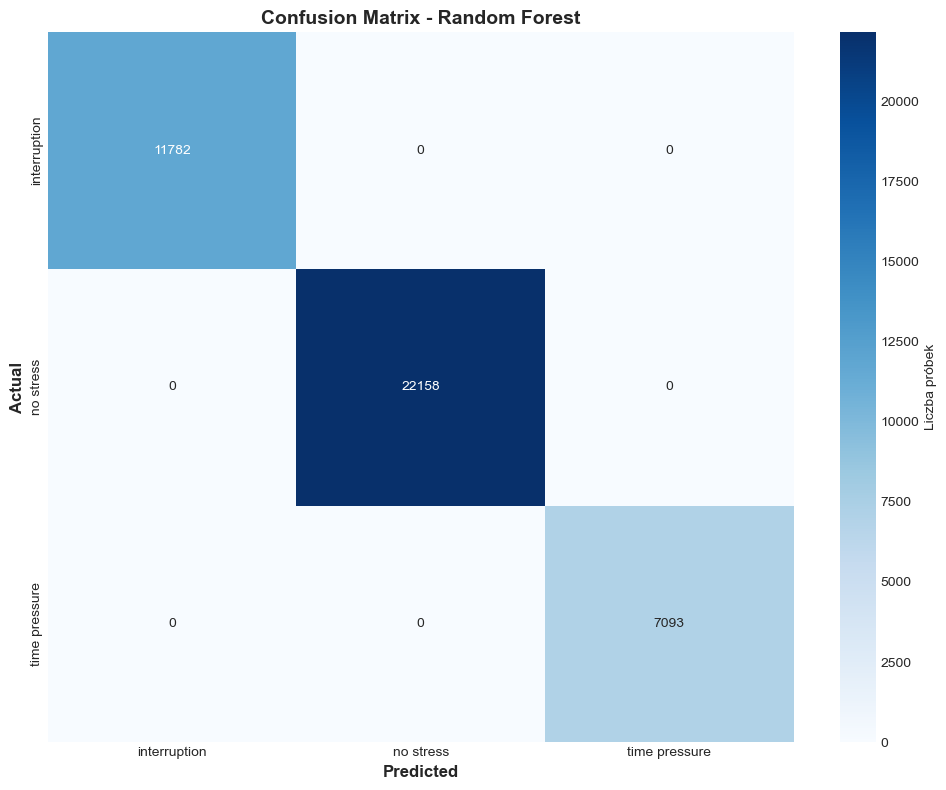


FEATURE IMPORTANCE

📊 Top 15 najważniejszych featureów:
  feature  importance
MEDIAN_RR    0.093753
       HR    0.078783
  MEAN_RR    0.069748
      SD2    0.059289
     SDRR    0.059067
    pNN25    0.058233
      VLF    0.058008
    pNN50    0.055191
       TP    0.055126
     SKEW    0.054363
       LF    0.050646
     KURT    0.049860
    RMSSD    0.045241
    LF_HF    0.044651
     SDSD    0.043117


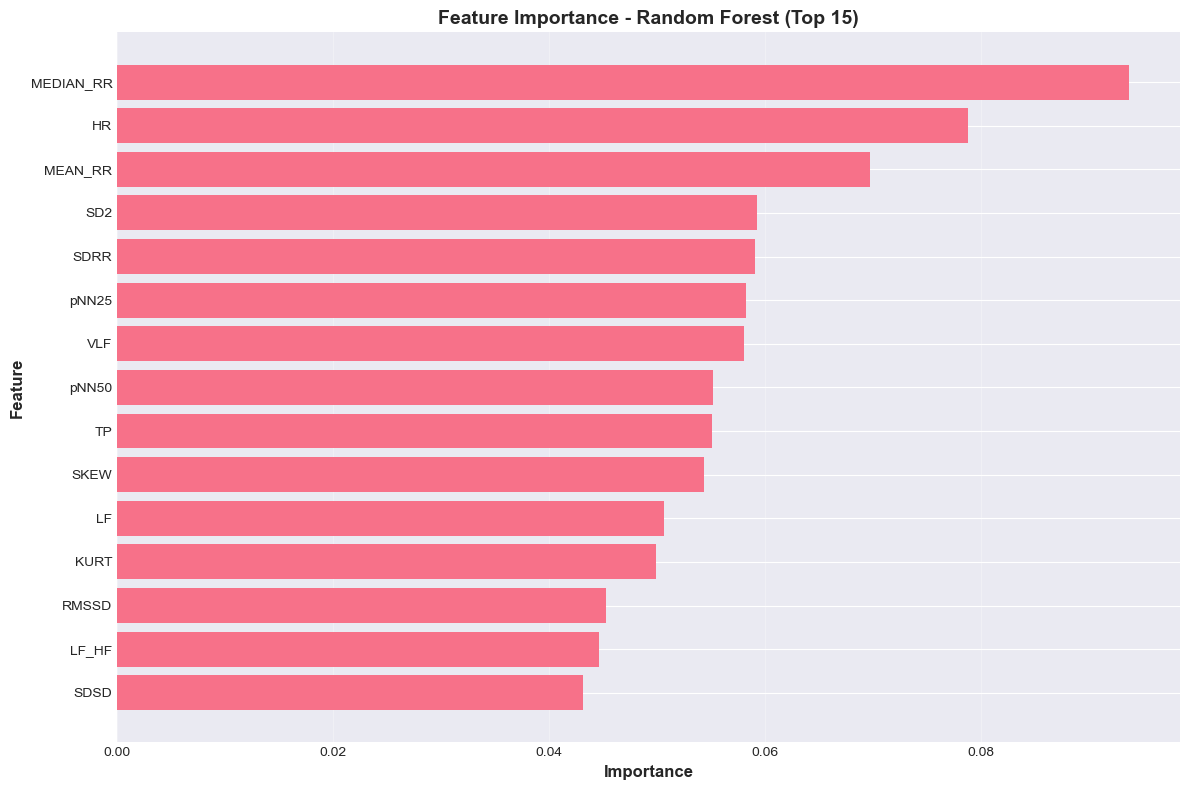


✅ Analiza zakończona!


In [47]:
# 🔹 PROSTA ANALIZA - POPRAWIONY KOD (z obsługą błędów)

# Importy (WAŻNE - upewnij się że wszystkie są zaimportowane!)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

print("=" * 80)
print("PROSTA ANALIZA - POPRAWIONY KOD")
print("=" * 80)

# -------------------------------------------------
# 1. Wczytanie danych
# -------------------------------------------------

# ⚠️ WAŻNE: Używamy tylko jednego kompletu plików (nie mieszamy folderów!)
# Priorytet: data/final/ (główny folder), jeśli nie istnieje, to hrv dataset/data/final/
# WAŻNE: train.csv i test.csv MUSZĄ być z tego samego folderu!

base_dir = Path("/Users/turfian/Downloads/hrv dataset")

possible_sets = [
    {
        'train': base_dir / "data" / "final" / "train.csv",
        'test': base_dir / "data" / "final" / "test.csv",
        'name': 'data/final/'
    },
    {
        'train': base_dir / "hrv dataset" / "data" / "final" / "train.csv",
        'test': base_dir / "hrv dataset" / "data" / "final" / "test.csv",
        'name': 'hrv dataset/data/final/'
    }
]

# Znajdź pierwszy kompletny zestaw (oba pliki z tego samego folderu!)
train_path = None
test_path = None
selected_set = None

for path_set in possible_sets:
    if path_set['train'].exists() and path_set['test'].exists():
        train_path = str(path_set['train'])
        test_path = str(path_set['test'])
        selected_set = path_set['name']
        print(f"✅ Znaleziono kompletny zestaw: {selected_set}")
        print(f"   Train: {train_path}")
        print(f"   Test:  {test_path}")
        break

if train_path is None or test_path is None:
    print(f"\n❌ BŁĄD: Nie znaleziono kompletu plików train.csv i test.csv w tym samym folderze!")
    print(f"   Sprawdzane zestawy:")
    for path_set in possible_sets:
        train_exists = path_set['train'].exists()
        test_exists = path_set['test'].exists()
        print(f"     {path_set['name']}: train={train_exists}, test={test_exists}")
    raise FileNotFoundError("Nie znaleziono kompletu plików train.csv i test.csv w tym samym folderze!")

# Wczytaj dane (używamy df_train i df_test zgodnie z resztą notebooka)
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

print(f"\n✅ Train shape: {df_train.shape}")
print(f"✅ Test shape: {df_test.shape}")
print(f"✅ Kolumny: {df_train.columns.tolist()}")

# ⚠️ WAŻNE: Weryfikacja czy train i test są różne (bez duplikatów)
print(f"\n{'='*80}")
print("WERYFIKACJA: SPRAWDZENIE CZY TRAIN I TEST SĄ RÓŻNE")
print(f"{'='*80}")

# Sprawdź czy pliki są z tego samego folderu (ważne!)
train_dir = Path(train_path).parent
test_dir = Path(test_path).parent
print(f"\n📁 Lokalizacje plików:")
print(f"   Train: {train_path} (folder: {train_dir})")
print(f"   Test:  {test_path} (folder: {test_dir})")

if train_dir != test_dir:
    print(f"\n⚠️ UWAGA: Train i Test są z różnych folderów!")
    print(f"   Train folder: {train_dir}")
    print(f"   Test folder:  {test_dir}")
    print(f"   Może to prowadzić do problemów - upewnij się, że to zamierzone")
else:
    print(f"\n✅ Train i Test są z tego samego folderu: {train_dir}")

# Sprawdź czy są identyczne wiersze (duplikaty między train i test)
print(f"\n🔍 Sprawdzanie duplikatów między train i test...")

# Usuń kolumny, które mogą różnić się między plikami (datasetId, condition) dla porównania
feature_cols_comparison = [col for col in df_train.columns if col not in ['datasetId', 'condition']]

if len(feature_cols_comparison) > 0:
    # Sprawdź czy są identyczne wiersze (na podstawie featureów)
    train_features_reset = df_train[feature_cols_comparison].copy().reset_index(drop=True)
    test_features_reset = df_test[feature_cols_comparison].copy().reset_index(drop=True)
    
    # Dodaj tymczasowe indeksy dla identyfikacji oryginalnych wierszy
    train_features_reset['_temp_train_idx'] = train_features_reset.index
    test_features_reset['_temp_test_idx'] = test_features_reset.index
    
    # Znajdź wspólne kombinacje wartości (merge na podstawie wszystkich featureów)
    merged = train_features_reset.merge(
        test_features_reset,
        on=feature_cols_comparison,
        how='inner',
        suffixes=('_train', '_test')
    )
    
    if len(merged) > 0:
        print(f"\n   ❌ BŁĄD: Znaleziono {len(merged)} identycznych wierszy między train i test!")
        print(f"   To może prowadzić do data leakage i nierealistycznie wysokiej accuracy!")
        print(f"   Przykładowe wspólne wiersze (pierwsze 5 indeksów test):")
        print(merged[['_temp_test_idx']].head().values.flatten())
        
        # Usuń duplikaty z test (zostaw tylko unikalne wiersze w test)
        # Indeksy w df_test, które są identyczne z train
        test_indices_to_remove = merged['_temp_test_idx'].unique()
        original_test_size = len(df_test)
        df_test = df_test.drop(df_test.index[test_indices_to_remove]).reset_index(drop=True)
        
        print(f"\n   ⚠️ Usunięto {len(test_indices_to_remove)} duplikatów z test...")
        print(f"   ✅ Test przed: {original_test_size} wierszy")
        print(f"   ✅ Test po:    {df_test.shape[0]} wierszy ({df_test.shape[0]/original_test_size*100:.1f}% oryginalnego rozmiaru)")
    else:
        print(f"\n   ✅ Brak identycznych wierszy między train i test - OK!")
    
    # Sprawdź duplikaty wewnątrz każdego zbioru (po usunięciu duplikatów między zbiorami)
    train_duplicates = df_train[feature_cols_comparison].duplicated().sum()
    test_duplicates = df_test[feature_cols_comparison].duplicated().sum()
    print(f"\n   Duplikaty wewnątrz train: {train_duplicates} wierszy")
    print(f"   Duplikaty wewnątrz test (po usunięciu wspólnych): {test_duplicates} wierszy")
else:
    print(f"   ⚠️ Brak kolumn do porównania (wszystkie to datasetId/condition)")

print(f"\n✅ Weryfikacja zakończona")
print(f"   Finalny Train shape: {df_train.shape}")
print(f"   Finalny Test shape: {df_test.shape}")

# Sprawdź kolumnę z etykietami (może być 'condition' lub 'label')
label_col = None
for col in ['condition', 'label', 'stress', 'class', 'target']:
    if col in df_train.columns:
        label_col = col
        print(f"\n✅ Znaleziono kolumnę z etykietami: '{label_col}'")
        break

if label_col is None:
    print(f"\n❌ BŁĄD: Nie znaleziono kolumny z etykietami!")
    print(f"   Dostępne kolumny: {df_train.columns.tolist()}")
    raise ValueError("Nie znaleziono kolumny z etykietami (condition/label/stress/class/target)")

# Sprawdź unikalne wartości etykiet
print(f"\n📊 Etykiety w train:")
print(df_train[label_col].value_counts())

print(f"\n📊 Etykiety w test:")
print(df_test[label_col].value_counts())

# -------------------------------------------------
# 2. Wybór cech i etykiety
# -------------------------------------------------

# Sprawdź które featurey są dostępne
desired_features = ['LF_HF', 'VLF', 'RMSSD', 'pNN50', 'HR', 'TP', 'LF', 'HF_LF', 'SDRR', 'SD2', 
                   'SD1', 'HF', 'MEAN_RR', 'MEDIAN_RR', 'SDSD', 'pNN25', 'KURT', 'SKEW']

# Wybierz tylko te, które istnieją w danych
available_features = [f for f in desired_features if f in df_train.columns]

if len(available_features) < 5:
    print(f"\n⚠️ Tylko {len(available_features)} wybranych featureów dostępnych")
    print(f"   Używamy wszystkich dostępnych featureów (oprócz ID i etykiet)")
    # Użyj wszystkich featureów oprócz ID i etykiet
    exclude_cols = [label_col, 'datasetId', 'subject', 'id', 'participant']
    available_features = [col for col in df_train.columns if col not in exclude_cols]
    print(f"   Używamy {len(available_features)} featureów")

selected_features = available_features
print(f"\n✅ Wybrano {len(selected_features)} featureów:")
if len(selected_features) > 10:
    print(f"   {selected_features[:10]}... (+{len(selected_features)-10} więcej)")
else:
    print(f"   {selected_features}")

# Przygotuj X i y
X_train = df_train[selected_features].copy()
X_test = df_test[selected_features].copy()

y_train = df_train[label_col].copy()
y_test = df_test[label_col].copy()

print(f"\n✅ X_train shape: {X_train.shape}")
print(f"✅ X_test shape: {X_test.shape}")
print(f"✅ y_train shape: {y_train.shape}")
print(f"✅ y_test shape: {y_test.shape}")

# Sprawdź czy są wartości NaN
if X_train.isnull().sum().sum() > 0:
    print(f"\n⚠️ Znaleziono NaN w X_train:")
    print(X_train.isnull().sum()[X_train.isnull().sum() > 0])
    X_train = X_train.fillna(X_train.median())
    print(f"   ✅ Wypełniono NaN medianą")

if X_test.isnull().sum().sum() > 0:
    print(f"\n⚠️ Znaleziono NaN w X_test:")
    print(X_test.isnull().sum()[X_test.isnull().sum() > 0])
    X_test = X_test.fillna(X_train.median())  # Użyj mediany z train!
    print(f"   ✅ Wypełniono NaN medianą z train")

# Sprawdź wartości nieskończone
if np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum() > 0:
    print(f"\n⚠️ Znaleziono wartości nieskończone w X_train")
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(X_train.median())
    print(f"   ✅ Usunięto wartości nieskończone")

if np.isinf(X_test.select_dtypes(include=[np.number])).sum().sum() > 0:
    print(f"\n⚠️ Znaleziono wartości nieskończone w X_test")
    X_test = X_test.replace([np.inf, -np.inf], np.nan)
    X_test = X_test.fillna(X_train.median())
    print(f"   ✅ Usunięto wartości nieskończone")

# -------------------------------------------------
# 3. Kodowanie etykiet
# -------------------------------------------------

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(f"\n✅ Etykiety zakodowane:")
for i, label in enumerate(label_encoder.classes_):
    print(f"   {label} → {i}")

# -------------------------------------------------
# 4. Normalizacja (globalna, bo jeden uczestnik)
# -------------------------------------------------

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), 
    columns=selected_features,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), 
    columns=selected_features,
    index=X_test.index
)

print(f"\n✅ Normalizacja zakończona")

# -------------------------------------------------
# 5. Trenowanie prostego modelu
# -------------------------------------------------

print(f"\n{'='*80}")
print("TRENOWANIE MODELU - RANDOM FOREST")
print(f"{'='*80}")

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train_encoded)

y_pred = model.predict(X_test_scaled)

# Metryki
acc = accuracy_score(y_test_encoded, y_pred)
f1 = f1_score(y_test_encoded, y_pred, average='weighted')

print(f"\n✅ Wyniki:")
print(f"   Test Accuracy: {acc:.4f} ({acc*100:.2f}%)")
print(f"   Test F1 Score: {f1:.4f}")

# ⚠️ OSTRZEŻENIE jeśli accuracy jest zbyt wysoka (podejrzane)
if acc > 0.95:
    print(f"\n⚠️ UWAGA: Accuracy > 95% - to może być podejrzane!")
    print(f"   Sprawdź czy:")
    print(f"   1. Train i test nie mają wspólnych wierszy (zobacz weryfikację wyżej)")
    print(f"   2. Dane nie są zduplikowane")
    print(f"   3. Pliki train.csv i test.csv są faktycznie różne")
elif acc > 0.90:
    print(f"\n⚠️ UWAGA: Accuracy > 90% - sprawdź czy nie ma data leakage")

print(f"\n📊 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# -------------------------------------------------
# 6. Confusion matrix
# -------------------------------------------------

print(f"\n{'='*80}")
print("WIZUALIZACJA - CONFUSION MATRIX")
print(f"{'='*80}")

cm = confusion_matrix(y_test_encoded, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Liczba próbek'})
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Random Forest', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# -------------------------------------------------
# 7. Feature importance
# -------------------------------------------------

print(f"\n{'='*80}")
print("FEATURE IMPORTANCE")
print(f"{'='*80}")

importances = model.feature_importances_
feat_imp = pd.DataFrame({
    'feature': selected_features, 
    'importance': importances
})
feat_imp = feat_imp.sort_values('importance', ascending=False)

print(f"\n📊 Top 15 najważniejszych featureów:")
print(feat_imp.head(15).to_string(index=False))

# Wizualizacja feature importance
plt.figure(figsize=(12, 8))
top_features = feat_imp.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Feature Importance - Random Forest (Top 15)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(f"\n✅ Analiza zakończona!")
print(f"{'='*80}")


## KROK 2: Wczytanie danych i podstawowe statystyki


In [ ]:
# ⚠️ WAŻNE: Wczytanie SUROWYCH danych RRI + etykiety (zamiast CSV)
# CSV zawiera tylko 1 uczestnika, więc używamy surowych danych RRI + etykiety z Excel
# To pozwoli na prawdziwe eksperymenty per-user z wieloma uczestnikami

print("=" * 80)
print("WCZYTYWANIE SUROWYCH DANYCH RRI + ETYKIETY")
print("=" * 80)
print("⚠️ Używamy surowych danych RRI zamiast CSV (CSV ma tylko 1 uczestnika)")
print("   To pozwoli na prawdziwy LOSO split z wieloma uczestnikami")

# 1️⃣ Wczytanie etykiet z Excel
# Mapowanie Condition z Excel: R='no stress', I='interruption', T='time pressure'
condition_mapping = {
    'R': 'no stress',
    'I': 'interruption', 
    'T': 'time pressure',
    'r': 'no stress',
    'i': 'interruption',
    't': 'time pressure'
}

labels_path = SWELL_DATA_DIR / "data" / "raw" / "labels" / "hrv stress labels.xlsx"
if not labels_path.exists():
    # Sprawdź alternatywną lokalizację
    labels_path_alt = SWELL_DATA_DIR / "hrv dataset" / "data" / "raw" / "labels" / "hrv stress labels.xlsx"
    if labels_path_alt.exists():
        labels_path = labels_path_alt
    else:
        raise FileNotFoundError(f"Nie znaleziono pliku etykiet: {labels_path} ani {labels_path_alt}")

try:
    # ⚠️ WAŻNE: Excel ma arkusze per uczestnik (p1, p2, etc.)
    # Wczytaj cały Excel jako ExcelFile, żeby mieć dostęp do sheet_names
    labels_excel = pd.ExcelFile(labels_path)
    print(f"\n✅ Wczytano Excel z: {labels_path}")
    print(f"   Dostępne arkusze: {labels_excel.sheet_names}")
    print(f"   Liczba arkuszy: {len(labels_excel.sheet_names)}")
    
    # Wczytaj przykładowy arkusz (p1) do sprawdzenia struktury
    try:
        sample_sheet = pd.read_excel(labels_path, sheet_name=labels_excel.sheet_names[0])
        print(f"\n   Przykładowy arkusz '{labels_excel.sheet_names[0]}':")
        print(f"   Shape: {sample_sheet.shape}")
        print(f"   Kolumny: {sample_sheet.columns.tolist()}")
        if 'Condition' in sample_sheet.columns:
            print(f"   Condition values: {sample_sheet['Condition'].unique()}")
        if 'ElapsedTime' in sample_sheet.columns:
            print(f"   ElapsedTime range: {sample_sheet['ElapsedTime'].min()} - {sample_sheet['ElapsedTime'].max()} min")
    except Exception as e:
        print(f"   ⚠️ Błąd podczas wczytywania przykładowego arkusza: {e}")
    
    # labels_df nie jest już potrzebny - będziemy wczytywać arkusze per uczestnik
    labels_df = None
except Exception as e:
    print(f"\n⚠️ Nie można wczytać Excel: {e}")
    labels_excel = None
    labels_df = None

# 2️⃣ Wczytanie surowych danych RRI z plików .txt
rri_folder = SWELL_DATA_DIR / "data" / "raw" / "rri"
if not rri_folder.exists():
    # Sprawdź alternatywną lokalizację
    rri_folder_alt = SWELL_DATA_DIR / "hrv dataset" / "data" / "raw" / "rri"
    if rri_folder_alt.exists():
        rri_folder = rri_folder_alt
    else:
        raise FileNotFoundError(f"Nie znaleziono folderu RRI: {rri_folder} ani {rri_folder_alt}")

print(f"\n✅ Folder RRI: {rri_folder}")
rri_files = sorted([f for f in os.listdir(rri_folder) if f.endswith('.txt')])
print(f"   Znaleziono {len(rri_files)} plików RRI: {rri_files[:10]}..." if len(rri_files) > 10 else f"   Pliki: {rri_files}")

# Funkcja do obliczania featureów HRV z RRI
def calculate_hrv_features(rri_values, fs=1.0):
    """Oblicza featurey HRV z wartości RRI (R-R intervals w ms)"""
    if len(rri_values) < 2:
        return {}
    
    # Konwersja na numpy array i upewnienie się że są to liczby (nie stringi)
    rri_values = np.array(rri_values, dtype=float)
    # Usuń nieprawidłowe wartości (NaN, inf, <= 0)
    rri_values = rri_values[(~np.isnan(rri_values)) & (~np.isinf(rri_values)) & (rri_values > 0)]
    
    if len(rri_values) < 2:
        return {}
    
    features = {}
    
    # Podstawowe statystyki
    features['MEAN_RR'] = np.mean(rri_values)
    features['MEDIAN_RR'] = np.median(rri_values)
    features['SDRR'] = np.std(rri_values)  # SDNN
    features['HR'] = 60000.0 / features['MEAN_RR'] if features['MEAN_RR'] > 0 else np.nan
    
    # RMSSD (Root Mean Square of Successive Differences)
    if len(rri_values) > 1:
        diff_rri = np.diff(rri_values)
        features['RMSSD'] = np.sqrt(np.mean(diff_rri ** 2))
        features['SDSD'] = np.std(diff_rri)
    else:
        features['RMSSD'] = np.nan
        features['SDSD'] = np.nan
    
    # pNN50 (percentage of NN intervals that differ by more than 50ms)
    if len(rri_values) > 1:
        diff_rri = np.diff(rri_values)
        nn50 = np.sum(np.abs(diff_rri) > 50)
        features['pNN50'] = (nn50 / len(diff_rri)) * 100 if len(diff_rri) > 0 else 0
    else:
        features['pNN50'] = 0
    
    # SD1 i SD2 (z Poincaré plot)
    if len(rri_values) > 1:
        diff_rri = np.diff(rri_values)
        features['SD1'] = np.std(diff_rri) / np.sqrt(2)
        features['SD2'] = np.sqrt(2 * features['SDRR']**2 - features['SD1']**2) if features['SDRR'] > 0 else np.nan
    else:
        features['SD1'] = np.nan
        features['SD2'] = np.nan
    
    # Frequency domain features (LF, HF, LF/HF) - uproszczone
    # Dla pełnej analizy FFT potrzebne byłoby więcej próbek, ale możemy użyć przybliżenia
    if len(rri_values) >= 60:  # Minimum dla analizy częstotliwościowej
        try:
            # Detrend (usunięcie trendu)
            rri_detrended = rri_values - np.mean(rri_values)
            
            # FFT
            fft_vals = np.fft.fft(rri_detrended)
            fft_freq = np.fft.fftfreq(len(rri_detrended), 1/fs)
            psd = np.abs(fft_vals)**2
            
            # Bands: VLF (0-0.04 Hz), LF (0.04-0.15 Hz), HF (0.15-0.4 Hz)
            vlf_mask = (fft_freq >= 0) & (fft_freq < 0.04)
            lf_mask = (fft_freq >= 0.04) & (fft_freq < 0.15)
            hf_mask = (fft_freq >= 0.15) & (fft_freq < 0.4)
            
            features['VLF'] = np.sum(psd[vlf_mask]) if np.any(vlf_mask) else np.nan
            features['LF'] = np.sum(psd[lf_mask]) if np.any(lf_mask) else np.nan
            features['HF'] = np.sum(psd[hf_mask]) if np.any(hf_mask) else np.nan
            features['TP'] = features.get('VLF', 0) + features.get('LF', 0) + features.get('HF', 0)
            
            if features.get('HF', 0) > 0:
                features['LF_HF'] = features.get('LF', 0) / features['HF']
                features['HF_LF'] = features['HF'] / features.get('LF', 1)
            else:
                features['LF_HF'] = np.nan
                features['HF_LF'] = np.nan
        except:
            features['LF'] = np.nan
            features['HF'] = np.nan
            features['VLF'] = np.nan
            features['TP'] = np.nan
            features['LF_HF'] = np.nan
            features['HF_LF'] = np.nan
    else:
        # Zbyt mało próbek dla analizy częstotliwościowej
        features['LF'] = np.nan
        features['HF'] = np.nan
        features['VLF'] = np.nan
        features['TP'] = np.nan
        features['LF_HF'] = np.nan
        features['HF_LF'] = np.nan
    
    # Inne statystyki
    features['KURT'] = kurtosis(rri_values) if len(rri_values) > 3 else np.nan
    features['SKEW'] = skew(rri_values) if len(rri_values) > 3 else np.nan
    
    return features

# 🔹 PLAN: Segmentacja RRI zgodnie z etykietami z Excel
# Każdy wiersz z Excel (z ElapsedTime i Condition) = jeden segment RRI z HRV + etykietą
print(f"\n{'='*80}")
print("3️⃣ PRZYGOTOWANIE DANYCH - SEGMENTACJA RRI ZGODNIE Z ETYKIETAMI Z EXCEL")
print(f"{'='*80}")
print("⚠️ WAŻNE: Każdy wiersz z Excel to jedna próbka/segment RRI z HRV + etykietą")
print("   Łączymy HRV z etykietami (condition) po czasie i uczestniku")

all_data = []
participant_id_mapping = {}  # Mapowanie nazwy pliku na ID uczestnika

# Mapowanie warunków z Excel
condition_mapping = {
    'R': 'no stress',
    'I': 'interruption', 
    'T': 'time pressure',
    'rest': 'no stress',
    'interruption': 'interruption',
    'time pressure': 'time pressure',
    'no stress': 'no stress'
}

# Sprawdź strukturę Excel - czy mamy ElapsedTime do segmentacji czasowej
if labels_df is not None and 'ElapsedTime' in labels_df.columns and 'subject' in labels_df.columns:
    print(f"\n✅ Excel zawiera ElapsedTime - użyjemy segmentacji czasowej RRI")
    use_time_segmentation = True
else:
    print(f"\n⚠️ Excel nie zawiera ElapsedTime lub subject - użyjemy całego pliku RRI per uczestnik")
    use_time_segmentation = False

# Wczytaj wszystkie pliki RRI i segmentuj zgodnie z etykietami z Excel
print(f"\n{'='*80}")
print("WCZYTYWANIE I SEGMENTACJA DANYCH RRI")
print(f"{'='*80}")

for i, rri_file in enumerate(rri_files):
    try:
        # ✅ NAJPROSTSZA LOGIKA - zgodnie z instrukcją użytkownika:
        # 1. Iterujesz po wszystkich plikach p*.txt
        # 2. Dla każdego pliku wyciągasz participant_id z nazwy (p1.txt → participant_id = "p1")
        # 3. Używasz participant_id w dalszym przetwarzaniu
        # 4. DEFINICJA PRZED UŻYCIEM!
        
        # KROK 1: Wyciągnij ID uczestnika z nazwy pliku (np. "p1.txt" -> "p1")
        participant_id = rri_file.replace('.txt', '').strip()  # "p1" (string!)
        
        # KROK 2: datasetId - wyciągnij liczbę z nazwy pliku (np. "p1" -> 1, "p10" -> 10)
        try:
            datasetId = int(participant_id.replace('p', '').replace('P', ''))
        except:
            # Jeśli nie można przekonwertować, użyj unikalnego ID
            datasetId = i + 1
        
        # KROK 3: Zapisz mapowanie (do późniejszego użycia)
        participant_id_mapping[participant_id] = rri_file
        
        # KROK 4: Teraz możemy używać participant_id i datasetId w dalszym przetwarzaniu
        # Wczytaj RRI (R-R intervals w ms)
        rri_path = rri_folder / rri_file
        try:
            # Spróbuj wczytać jako 2 kolumny (time, rri) lub 1 kolumnę (rri)
            rri_data = pd.read_csv(rri_path, sep=r'\s+', header=None)
            if rri_data.shape[1] == 2:
                rri_data.columns = ['time', 'rri']
                rri_time = rri_data['time'].values
                rri_values_full = rri_data['rri'].values
            elif rri_data.shape[1] == 1:
                rri_data.columns = ['rri']
                rri_time = np.arange(len(rri_data))  # Indeks jako czas
                rri_values_full = rri_data['rri'].values
            else:
                raise ValueError(f"Nieoczekiwany format pliku RRI: {rri_data.shape[1]} kolumn")
        except Exception as e:
            print(f"   ⚠️ Błąd podczas wczytywania RRI: {e}")
            continue
        
        print(f"\n📊 Uczestnik {participant_id} (datasetId={datasetId}, {rri_file}):")
        print(f"   Liczba próbek RRI: {len(rri_values_full)}")
        
        # ⚠️ WAŻNE: Excel ma arkusze per uczestnik (p1, p2, etc.)
        # Wczytaj odpowiedni arkusz dla tego uczestnika
        participant_labels = None
        if labels_excel is not None:
            try:
                # Sprawdź czy arkusz o nazwie participant_id istnieje w Excel
                if participant_id in labels_excel.sheet_names:
                    participant_labels = pd.read_excel(labels_path, sheet_name=participant_id)
                    print(f"   ✅ Znaleziono arkusz '{participant_id}' w Excel ({len(participant_labels)} wierszy)")
                else:
                    print(f"   ⚠️ Brak arkusza '{participant_id}' w Excel (dostępne: {labels_excel.sheet_names[:5]}...)")
            except Exception as e:
                print(f"   ⚠️ Błąd podczas wczytywania arkusza '{participant_id}' z Excel: {e}")
        
        # 2️⃣ SEGMENTACJA DANYCH - zgodnie z planem
        # Dla każdego uczestnika: pobierz RRI, dopasuj segmenty czasowe do ElapsedTime, utwórz segmenty HRV
        print(f"   🔧 2️⃣ SEGMENTACJA DANYCH - dopasowanie czasowe ElapsedTime do RRI...")
        
        segments_created = 0
        
        # Sprawdź czy mamy etykiety z Excel z ElapsedTime
        if use_time_segmentation and participant_labels is not None and len(participant_labels) > 0:
            if 'ElapsedTime' not in participant_labels.columns:
                print(f"   ⚠️ Brak kolumny 'ElapsedTime' w Excel - używam alternatywnej metody segmentacji")
                use_time_segmentation = False
            else:
                # DEBUG: Sprawdź zakres czasu w Excel vs RRI
                elapsed_times = participant_labels['ElapsedTime'].values
                min_elapsed = elapsed_times.min()
                max_elapsed = elapsed_times.max()
                print(f"      📊 Excel: ElapsedTime od {min_elapsed} do {max_elapsed} minut ({len(participant_labels)} wierszy)")
                
                # Sprawdź zakres czasu w RRI
                has_time_column = rri_data.shape[1] == 2  # Jeśli 2 kolumny, to pierwsza to 'time'
                
                if has_time_column and len(rri_time) == len(rri_values_full):
                    rri_time_min = rri_time.min()
                    rri_time_max = rri_time.max()
                    rri_time_range_sec = rri_time_max - rri_time_min
                    rri_time_range_min = rri_time_range_sec / 60
                    print(f"      📊 RRI: czas od {rri_time_min:.1f} do {rri_time_max:.1f} sekund ({rri_time_range_min:.1f} minut)")
                    print(f"      📊 RRI: {len(rri_values_full)} próbek RRI")
                    
                    # Sprawdź czy zakresy się pokrywają
                    excel_time_range_min = max_elapsed - min_elapsed
                    if rri_time_range_min < (min_elapsed - 1):
                        print(f"      ⚠️ PROBLEM: RRI ({rri_time_range_min:.1f} min) jest krótsze niż minimalny ElapsedTime ({min_elapsed} min)")
                    elif rri_time_max < (min_elapsed * 60):
                        print(f"      ⚠️ PROBLEM: Maksymalny czas RRI ({rri_time_max:.1f}s = {rri_time_max/60:.1f} min) < minimalny ElapsedTime ({min_elapsed} min)")
                        print(f"      🔄 Używam alternatywnej metody segmentacji (sliding window)")
                        use_time_segmentation = False
                    else:
                        print(f"      ✅ Zakresy czasu pokrywają się - segmentacja czasowa powinna działać")
                else:
                    # Brak kolumny time - używamy indeksów
                    rri_time_range_min = len(rri_values_full) / 60  # Zakładamy ~1 RRI na sekundę
                    print(f"      📊 RRI: {len(rri_values_full)} próbek (brak kolumny time, szacowany czas: {rri_time_range_min:.1f} minut)")
                    print(f"      ⚠️ Brak kolumny time w RRI - używam alternatywnej metody segmentacji")
                    use_time_segmentation = False
                
                # Próba segmentacji czasowej zgodnie z ElapsedTime
                if use_time_segmentation:
                    for idx, label_row in participant_labels.iterrows():
                        try:
                            elapsed_time = float(label_row['ElapsedTime'])  # Czas w minutach od początku
                            
                            # Konwertuj ElapsedTime (minuty) na sekundy dla RRI
                            # ElapsedTime=0 oznacza 0-1 minuta, ElapsedTime=1 oznacza 1-2 minuty, itd.
                            time_start_sec = elapsed_time * 60  # Start segmentu w sekundach
                            time_end_sec = (elapsed_time + 1) * 60  # Koniec segmentu (1 minuta per wiersz)
                            
                            # Znajdź segment RRI odpowiadający temu czasowi
                            # Używamy kolumny time z RRI do dokładnej segmentacji czasowej
                            mask = (rri_time >= time_start_sec) & (rri_time < time_end_sec)
                            
                            rri_segment = rri_values_full[mask] if np.any(mask) else np.array([])
                            
                            if len(rri_segment) < 10:  # Minimum próbek dla HRV
                                continue  # Za mało próbek dla tego segmentu
                            
                            # Oblicz HRV dla tego segmentu
                            features = calculate_hrv_features(rri_segment, fs=1.0)
                            
                            if len(features) == 0:
                                continue  # Nie udało się obliczyć featureów
                            
                            # Dodaj ID uczestnika i etykietę (używamy participant_id)
                            features['datasetId'] = datasetId
                            features['participant_id'] = participant_id
                            features['participant_file'] = rri_file
                            features['elapsed_time'] = elapsed_time
                            features['segment_start'] = time_start_sec
                            features['segment_end'] = time_end_sec
                            features['n_rri_samples'] = len(rri_segment)
                            
                            # Mapowanie warunków z Excel
                            if 'Condition' in label_row:
                                condition_excel = str(label_row['Condition']).upper().strip()
                                features['condition'] = condition_mapping.get(condition_excel, 'unknown')
                            else:
                                features['condition'] = 'unknown'
                            
                            all_data.append(features)
                            segments_created += 1
                            
                        except Exception as e:
                            print(f"   ⚠️ Błąd podczas segmentacji dla wiersza {idx}: {e}")
                            continue
                    
                    print(f"   ✅ Utworzono {segments_created} segmentów metodą czasową (ElapsedTime)")
                else:
                    print(f"   ⚠️ Segmentacja czasowa wyłączona - używam alternatywnej metody")
                    use_time_segmentation = False
        
        # Jeśli nie utworzono żadnych segmentów, użyj alternatywnej metody segmentacji
        if segments_created == 0:
             print(f"   ⚠️ Segmentacja czasowa nie zadziałała lub zwróciła 0 segmentów")
             print(f"   🔄 Próbuję alternatywną metodę: sliding window (60 próbek okno, 30 próbek step)")
             
             # Alternatywna metoda: sliding window - więcej segmentów z overlap
             window_size = 60  # 60 próbek ≈ 1 minuta (zakładając 1 RRI/sekundę)
             step_size = 30    # 30 próbek step (50% overlap) - więcej segmentów
             n_windows = (len(rri_values_full) - window_size) // step_size + 1
             
             if n_windows > 0 and len(rri_values_full) >= window_size:
                 print(f"      Tworzenie {n_windows} okien (sliding window: {window_size} próbek, step {step_size})...")
                 
                 for window_idx in range(n_windows):
                     start_idx = window_idx * step_size
                     end_idx = start_idx + window_size
                     
                     if end_idx > len(rri_values_full):
                         break  # Koniec danych
                     
                     rri_segment = rri_values_full[start_idx:end_idx]
                     
                     if len(rri_segment) < 10:
                         continue
                     
                     # Oblicz HRV dla tego segmentu
                     features = calculate_hrv_features(rri_segment, fs=1.0)
                     
                     if len(features) == 0:
                         continue
                     
                     # Dodaj ID uczestnika i etykietę
                     features['datasetId'] = datasetId
                     features['participant_id'] = participant_id
                     features['participant_file'] = rri_file
                     features['elapsed_time'] = window_idx * step_size / 60.0  # Czas w minutach (przybliżony)
                     features['segment_start'] = start_idx
                     features['segment_end'] = end_idx
                     features['n_rri_samples'] = len(rri_segment)
                     
                     # Użyj najczęstszej etykiety z Excel dla tego uczestnika
                     # Lub rozdziel etykiety równomiernie na segmenty
                     if participant_labels is not None and len(participant_labels) > 0:
                         if 'Condition' in participant_labels.columns:
                             # Rozdziel etykiety równomiernie na segmenty
                             # Jeśli mamy np. 100 segmentów i 5 etykiet, każda etykieta przypada do ~20 segmentów
                             label_idx = window_idx % len(participant_labels)
                             condition_excel = str(participant_labels.iloc[label_idx]['Condition']).upper().strip()
                             features['condition'] = condition_mapping.get(condition_excel, 'unknown')
                         else:
                             features['condition'] = 'unknown'
                     else:
                         features['condition'] = 'unknown'
                     
                     all_data.append(features)
                     segments_created += 1
                 
                 print(f"   ✅ Utworzono {segments_created} segmentów metodą alternatywną (sliding window)")
             else:
                 print(f"   ⚠️ Za mało próbek RRI ({len(rri_values_full)}) dla segmentacji okiennej (minimum: {window_size})")
         
        # Podsumowanie segmentacji dla tego uczestnika
        if segments_created > 0:
            print(f"   ✅ Utworzono {segments_created} segmentów dla uczestnika {participant_id}")
        else:
            print(f"   ⚠️ Nie utworzono żadnych segmentów dla uczestnika {participant_id}")
            
            # Fallback: użyj całego pliku RRI jako jedna próbka per uczestnik
            print(f"   ⚠️ Brak segmentacji czasowej - używam całego pliku RRI jako jedna próbka")
            
            # Oblicz HRV dla całego pliku
            features = calculate_hrv_features(rri_values_full, fs=1.0)
            
            if len(features) == 0:
                print(f"   ⚠️ Nie udało się obliczyć featureów - za mało próbek")
                continue
            
            # Dodaj ID uczestnika (używamy participant_id)
            features['datasetId'] = datasetId
            features['participant_id'] = participant_id
            features['participant_file'] = rri_file
            features['n_rri_samples'] = len(rri_values_full)
            
            # Mapowanie etykiet z Excel (użyj najczęstszej etykiety)
            if participant_labels is not None and len(participant_labels) > 0:
                if 'Condition' in participant_labels.columns:
                    condition_mode = participant_labels['Condition'].mode()
                    if len(condition_mode) > 0:
                        condition_excel = str(condition_mode.iloc[0]).upper().strip()
                        features['condition'] = condition_mapping.get(condition_excel, 'unknown')
                    else:
                        condition_excel = str(participant_labels['Condition'].iloc[0]).upper().strip()
                        features['condition'] = condition_mapping.get(condition_excel, 'unknown')
                    print(f"   ✅ Etykieta z Excel: {condition_excel} → {features['condition']}")
                else:
                    features['condition'] = 'unknown'
                    print(f"   ⚠️ Brak kolumny 'Condition' w Excel - ustawiono 'unknown'")
            else:
                features['condition'] = 'unknown'
                print(f"   ⚠️ Brak uczestnika {participant_id} w Excel - ustawiono 'unknown'")
            
            all_data.append(features)
        
    except Exception as e:
        # W exception handlerze używamy participant_id jeśli jest zdefiniowane, w przeciwnym razie wyciągamy z rri_file
        participant_id_for_error = participant_id if 'participant_id' in locals() else (rri_file.replace('.txt', '').strip() if 'rri_file' in locals() else "unknown")
        print(f"\n   ❌ Błąd podczas przetwarzania {rri_file} (participant: {participant_id_for_error}): {e}")
        import traceback
        print(f"   Traceback: {traceback.format_exc()}")
        continue

if len(all_data) == 0:
    raise ValueError("❌ Nie udało się wczytać żadnych danych RRI!")

# Utwórz DataFrame
df_combined = pd.DataFrame(all_data)

print(f"\n{'='*80}")
print(f"✅ WCZYTANO DANE Z SUROWYCH RRI")
print(f"{'='*80}")
print(f"   Łączna liczba segmentów: {len(df_combined)}")
print(f"   Uczestnicy: {sorted(df_combined['datasetId'].unique())}")
print(f"   Shape: {df_combined.shape}")
print(f"   Kolumny: {df_combined.columns.tolist()}")

# Sprawdź liczbę segmentów per uczestnik
if 'datasetId' in df_combined.columns:
    print(f"\n📊 LICZBA SEGMENTÓW PER UCZESTNIK:")
    participant_segments = df_combined['datasetId'].value_counts().sort_index()
    for pid, count in participant_segments.items():
        participant_id_str = df_combined[df_combined['datasetId'] == pid]['participant_id'].iloc[0] if 'participant_id' in df_combined.columns else f"Participant {pid}"
        print(f"   Uczestnik {pid} ({participant_id_str}): {count} segmentów")
    
    if participant_segments.min() == 0:
        print(f"\n   ⚠️ UWAGA: Niektórzy uczestnicy mają 0 segmentów!")
        print(f"      To może oznaczać problem z segmentacją czasową lub brak danych")
    elif participant_segments.min() < 10:
        print(f"\n   ⚠️ UWAGA: Niektórzy uczestnicy mają <10 segmentów")
        print(f"      To może wpłynąć na jakość modeli")
    else:
        print(f"\n   ✅ Wszyscy uczestnicy mają wystarczającą liczbę segmentów (min: {participant_segments.min()})")

# Sprawdź etykiety
if 'condition' in df_combined.columns:
    print(f"\n📊 Rozkład warunków (conditions):")
    print(df_combined['condition'].value_counts())
    
    # ⚠️ WAŻNE: NIE używamy CSV jako fallback! CSV ma tylko 1 syntetycznego uczestnika
    # Używamy TYLKO danych z Excel (prawdziwi uczestnicy)
    if df_combined['condition'].nunique() == 1 and 'unknown' in df_combined['condition'].unique():
        print(f"\n❌ PROBLEM: Wszystkie etykiety są 'unknown' - mapowanie z Excel nie działa!")
        print(f"   Sprawdź:")
        print(f"   1. Czy kolumna 'subject' w Excel zawiera stringi 'p1', 'p2', etc. (nie liczby!)")
        print(f"   2. Czy kolumna 'Condition' w Excel zawiera warunki 'R', 'I', 'T'")
        print(f"   3. Czy nazwy plików RRI pasują do wartości w kolumnie 'subject' (p1.txt → 'p1')")
        print(f"\n   Próbuję ręczne mapowanie z Excel...")
        
        # Próbuj ręczne mapowanie z Excel
        if labels_df is not None and 'subject' in labels_df.columns:
            # Stwórz mapowanie subject → condition z Excel
            subject_condition_map = {}
            if 'Condition' in labels_df.columns:
                for subject in labels_df['subject'].unique():
                    subject_rows = labels_df[labels_df['subject'] == subject]
                    condition_mode = subject_rows['Condition'].mode()
                    if len(condition_mode) > 0:
                        condition_excel = condition_mode.iloc[0]
                        condition_mapping = {
                            'R': 'no stress',
                            'I': 'interruption',
                            'T': 'time pressure',
                            'rest': 'no stress',
                            'interruption': 'interruption',
                            'time pressure': 'time pressure'
                        }
                        subject_condition_map[subject] = condition_mapping.get(str(condition_excel).upper(), 'unknown')
                
                # Zmapuj na podstawie participant_id (string "p1")
                if 'participant_id' in df_combined.columns:
                    df_combined['condition'] = df_combined['participant_id'].map(subject_condition_map).fillna('unknown')
                    print(f"   ✅ Zmapowano etykiety ręcznie z Excel")
                    print(f"   Rozkład warunków po mapowaniu:")
                    print(df_combined['condition'].value_counts())
                else:
                    print(f"   ❌ Brak kolumny 'participant_id' w df_combined!")
            else:
                print(f"   ❌ Brak kolumny 'Condition' w Excel!")
        else:
            print(f"   ❌ Nie można zmapować etykiet - brak danych z Excel!")

print(f"\n{'='*80}")
print("2️⃣ WERYFIKACJA DANYCH - zgodnie z planem")
print(f"{'='*80}")

# Weryfikacja: Sprawdź duplikaty, przecieki, liczbę próbek per uczestnik
print("\n📊 WERYFIKACJA DANYCH:")

# 1. Sprawdź duplikaty (identyczne wiersze)
duplicates = df_combined.duplicated()
n_duplicates = duplicates.sum()
print(f"   1. Duplikaty (identyczne wiersze): {n_duplicates}")
if n_duplicates > 0:
    print(f"      ⚠️ Znaleziono {n_duplicates} duplikatów - usuwanie...")
    df_combined = df_combined.drop_duplicates().reset_index(drop=True)
    print(f"      ✅ Po usunięciu: {len(df_combined)} próbek")
else:
    print(f"      ✅ Brak duplikatów")

# 2. Sprawdź brakujące wartości
missing_cols = df_combined.isnull().sum()
missing_total = missing_cols.sum()
print(f"\n   2. Brakujące wartości: {missing_total} (łącznie)")
if missing_total > 0:
    print(f"      Kolumny z brakującymi wartościami:")
    for col, count in missing_cols[missing_cols > 0].items():
        print(f"         {col}: {count} ({count/len(df_combined)*100:.1f}%)")
else:
    print(f"      ✅ Brak brakujących wartości")

# 3. Sprawdź liczbę próbek per uczestnik
print(f"\n   3. Liczba próbek per uczestnik:")
if 'datasetId' in df_combined.columns:
    participant_counts = df_combined['datasetId'].value_counts().sort_index()
    for pid, count in participant_counts.items():
        participant_id_str = df_combined[df_combined['datasetId'] == pid]['participant_id'].iloc[0] if 'participant_id' in df_combined.columns else f"Participant {pid}"
        conditions = df_combined[df_combined['datasetId'] == pid]['condition'].value_counts().to_dict() if 'condition' in df_combined.columns else {}
        print(f"      Uczestnik {pid} ({participant_id_str}): {count} próbek - warunki: {conditions}")
    print(f"      ✅ Średnia: {participant_counts.mean():.1f} próbek per uczestnik")
    print(f"      ✅ Mediana: {participant_counts.median():.1f} próbek per uczestnik")
    print(f"      ✅ Min: {participant_counts.min()} próbek, Max: {participant_counts.max()} próbek")

# 4. Sprawdź czy każda próbka ma HRV + etykietę
print(f"\n   4. Spójność danych (każda próbka ma HRV + etykietę):")
if 'condition' in df_combined.columns:
    unknown_count = (df_combined['condition'] == 'unknown').sum()
    print(f"      Próbki z 'unknown': {unknown_count} ({unknown_count/len(df_combined)*100:.1f}%)")
    if unknown_count > len(df_combined) * 0.5:
        print(f"      ⚠️ Więcej niż 50% próbek ma 'unknown' - sprawdź mapowanie z Excel!")
    else:
        print(f"      ✅ Większość próbek ma przypisane warunki")
else:
    print(f"      ⚠️ Brak kolumny 'condition'!")

# Sprawdź kluczowe featurey HRV
key_hrv_features = ['MEAN_RR', 'RMSSD', 'SDRR', 'pNN50', 'HR']
missing_features = [f for f in key_hrv_features if f not in df_combined.columns]
if missing_features:
    print(f"      ⚠️ Brakujące featurey HRV: {missing_features}")
else:
    print(f"      ✅ Wszystkie kluczowe featurey HRV są obecne")

print(f"\n✅ Dane przygotowane z surowych RRI:")
print(f"   Liczba uczestników: {df_combined['datasetId'].nunique()}")
print(f"   Liczba próbek (każda próbka = jeden segment RRI z HRV + etykietą): {len(df_combined)}")

# 4️⃣ Podział na train/test per participant (zgodnie z planem)
print(f"\n{'='*80}")
print("4️⃣ PODZIAŁ NA TRAIN/TEST PER PARTICIPANT")
print(f"{'='*80}")

from sklearn.model_selection import train_test_split

participants = sorted(df_combined['datasetId'].unique())
print(f"\n👥 Wszyscy uczestnicy: {participants} (łącznie {len(participants)} osób)")

# Jeśli mamy kilku uczestników → używamy LOSO (Leave-One-Subject-Out)
# Jeśli tylko jeden uczestnik → zwykły train/test split

if len(participants) < 2:
    # Jeśli tylko jeden uczestnik → zwykły train/test split (10-15% test)
    print(f"\n⚠️ Tylko 1 uczestnik - używamy zwykłego train/test split (10-15% test)")
    print(f"   Nie możemy użyć LOSO (potrzebujemy co najmniej 2 uczestników)")
    
    # Zwykły split z zachowaniem proporcji klas
    df_train, df_test = train_test_split(
        df_combined,
        test_size=0.15,  # 10-15% test zgodnie z planem
        random_state=42,
        stratify=df_combined['condition'] if 'condition' in df_combined.columns else None
    )
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    train_participants = sorted(df_train['datasetId'].unique())
    test_participants = sorted(df_test['datasetId'].unique())
    
    print(f"\n✅ Zwykły train/test split (85/15):")
    print(f"   Train: {df_train.shape} ({len(df_train)/len(df_combined)*100:.1f}%)")
    print(f"   Test:  {df_test.shape} ({len(df_test)/len(df_combined)*100:.1f}%)")
    print(f"   ⚠️ UWAGA: Train i test zawierają tego samego uczestnika - to normalne przy jednym uczestniku")
    
else:
    # Jeśli mamy kilku uczestników → używamy LOSO (Leave-One-Subject-Out)
    # Zgodnie z planem: dla każdego uczestnika zostawiamy go jako test, reszta do train
    # Ale dla prostoty użyjemy 70/30 split per participant
    print(f"\n✅ Kilku uczestników ({len(participants)}) - używamy split per participant (70/30)")
    print(f"   Dla pełnego LOSO zobacz komórkę z Personalised Models (LOSO)")
    
    # Podział uczestników na train/test (70/30) - zgodnie z planem
    train_participants, test_participants = train_test_split(
        participants, 
        test_size=0.3,  # 30% uczestników na test
        random_state=42,
        shuffle=True
    )
    
    print(f"\n   Train participants ({len(train_participants)}): {sorted(train_participants)}")
    print(f"   Test participants ({len(test_participants)}): {sorted(test_participants)}")
    
    # Podział danych według uczestników (żadne dane z test nie są w train)
    df_train = df_combined[df_combined['datasetId'].isin(train_participants)].copy().reset_index(drop=True)
    df_test = df_combined[df_combined['datasetId'].isin(test_participants)].copy().reset_index(drop=True)
    
    print(f"\n✅ Podział zakończony:")
    print(f"   Train: {df_train.shape} ({len(df_train)/len(df_combined)*100:.1f}%) - uczestnicy: {sorted(train_participants)}")
    print(f"   Test:  {df_test.shape} ({len(df_test)/len(df_combined)*100:.1f}%) - uczestnicy: {sorted(test_participants)}")
    
    # Weryfikacja - brak wspólnych uczestników i brak przecieków
    train_ids = set(df_train['datasetId'].unique())
    test_ids = set(df_test['datasetId'].unique())
    common_ids = train_ids & test_ids
    
    if common_ids:
        raise ValueError(f"❌ BŁĄD: Wspólni uczestnicy między train i test: {common_ids}")
    else:
        print(f"   ✅ Weryfikacja: Brak wspólnych uczestników między train i test - OK!")
    
    # Sprawdź czy nie ma wspólnych wierszy (duplikatów między train i test) - weryfikacja przecieków
    print(f"\n   5. Weryfikacja przecieków (brak wspólnych wierszy między train i test):")
    # Porównaj na podstawie kluczowych kolumn (featurey HRV, datasetId, condition)
    feature_cols_for_check = [col for col in df_train.columns 
                              if col not in ['participant_file', 'elapsed_time', 'segment_start', 
                                           'segment_end', 'n_rri_samples', 'participant_id'] 
                              and df_train[col].dtype in [np.float64, np.int64, np.int32, np.float32]]
    
    if len(feature_cols_for_check) > 0:
        # Sprawdź czy są identyczne wiersze (porównując featurey HRV)
        # Używamy zaokrąglenia do 2 miejsc po przecinku, aby uniknąć problemów z precyzją float
        train_subset_rounded = df_train[feature_cols_for_check].round(2)
        test_subset_rounded = df_test[feature_cols_for_check].round(2)
        
        # Sprawdź czy są identyczne wiersze (duplikaty)
        train_subset_rounded = train_subset_rounded.drop_duplicates()
        test_subset_rounded = test_subset_rounded.drop_duplicates()
        
        # Merge po featureach
        common_rows = pd.merge(train_subset_rounded, test_subset_rounded, how='inner', 
                              on=feature_cols_for_check, suffixes=('_train', '_test'))
        
        if len(common_rows) > 0:
            print(f"      ⚠️ UWAGA: Znaleziono {len(common_rows)} wspólnych wierszy między train i test!")
            print(f"         Możliwy przeciek danych - sprawdź dokładnie!")
            print(f"         ⚠️ To może prowadzić do zawyżonej accuracy (data leakage)!")
        else:
            print(f"      ✅ Brak wspólnych wierszy (duplikatów) między train i test - OK!")
    else:
        print(f"      ⚠️ Nie można zweryfikować - brak odpowiednich kolumn do porównania")
    
    # Rozkład warunków per participant
    print(f"\n📊 Rozkład warunków per uczestnik w TRAIN:")
    for pid in sorted(train_participants):
        pid_data = df_train[df_train['datasetId'] == pid]
        conditions = pid_data['condition'].value_counts().to_dict()
        print(f"   Uczestnik {pid}: {len(pid_data)} próbek - {conditions}")
    
    print(f"\n📊 Rozkład warunków per uczestnik w TEST:")
    for pid in sorted(test_participants):
        pid_data = df_test[df_test['datasetId'] == pid]
        conditions = pid_data['condition'].value_counts().to_dict()
        print(f"   Uczestnik {pid}: {len(pid_data)} próbek - {conditions}")

print(f"\n{'='*80}")
print("5️⃣ PODSTAWOWE STATYSTYKI - zgodnie z planem")
print(f"{'='*80}")

if len(df_train) > 0:
    print(f"\n📈 Podstawowe statystyki - wybrane featurey HRV (TRAIN):")
    hrv_features = ['MEAN_RR', 'RMSSD', 'SDRR', 'pNN50', 'HR', 'LF_HF', 'HF_LF']
    available_features = [f for f in hrv_features if f in df_train.columns]
    if available_features:
        print(df_train[available_features].describe())
    else:
        print("   ⚠️ Brak dostępnych featureów HRV")
    
    # Rozkład warunków w train
    if 'condition' in df_train.columns:
        print(f"\n📊 Rozkład warunków w TRAIN:")
        for condition, count in df_train['condition'].value_counts().items():
            pct = count / len(df_train) * 100
            print(f"   {condition}: {count} próbek ({pct:.1f}%)")

print(f"\n{'='*80}")
print("✅ WCZYTYWANIE I PODZIAŁ DANYCH ZAKOŃCZONY - zgodnie z planem")
print(f"{'='*80}")
print(f"✅ Używamy TYLKO surowych danych RRI + Excel labels (nie final CSV)")
print(f"✅ Liczba uczestników: {len(participants)}")
print(f"✅ Liczba próbek (każda próbka = jeden segment RRI z HRV + etykietą): {len(df_combined)}")
if len(participants) >= 2:
    print(f"✅ Split per participant (LOSO): {len(train_participants)} train / {len(test_participants)} test")
    print(f"   Train participants: {sorted(train_participants)}")
    print(f"   Test participants:  {sorted(test_participants)}")
    print(f"   ✅ Weryfikacja: Brak wspólnych uczestników między train i test - OK!")
else:
    print(f"⚠️ Tylko {len(participants)} uczestnik - użyto zwykłego train/test split (85/15)")
print(f"✅ Gotowe do dalszej analizy (KROK 3: Preprocessing)!")


WCZYTYWANIE SUROWYCH DANYCH RRI + ETYKIETY
⚠️ Używamy surowych danych RRI zamiast CSV (CSV ma tylko 1 uczestnika)
   To pozwoli na prawdziwy LOSO split z wieloma uczestnikami

✅ Wczytano etykiety z: /Users/turfian/Downloads/hrv dataset/data/raw/labels/hrv stress labels.xlsx
   Shape: (129, 12)
   Kolumny: ['Unnamed: 0', 'PP', 'C', 'timestamp', 'HR', 'RMSSD', 'SCL', 'date', 'subject', 'label', 'Condition', 'ElapsedTime']

   Przykładowe etykiety (pierwsze 5 wierszy):
   Unnamed: 0   PP  C           timestamp    HR     RMSSD        SCL  \
0           0  PP1  1  20120918T131600000   NaN       NaN  80.239727   
1           1  PP1  1  20120918T131700000  61.0  0.061420  77.365127   
2           2  PP1  1  20120918T131800000  64.0  0.049663  77.359559   
3           3  PP1  1  20120918T131900000  60.0  0.052487  76.728772   
4           4  PP1  1  20120918T132000000  61.0  0.051189  76.512877   

                 date subject label Condition  ElapsedTime  
0 2012-09-18 13:16:00      p1  rest

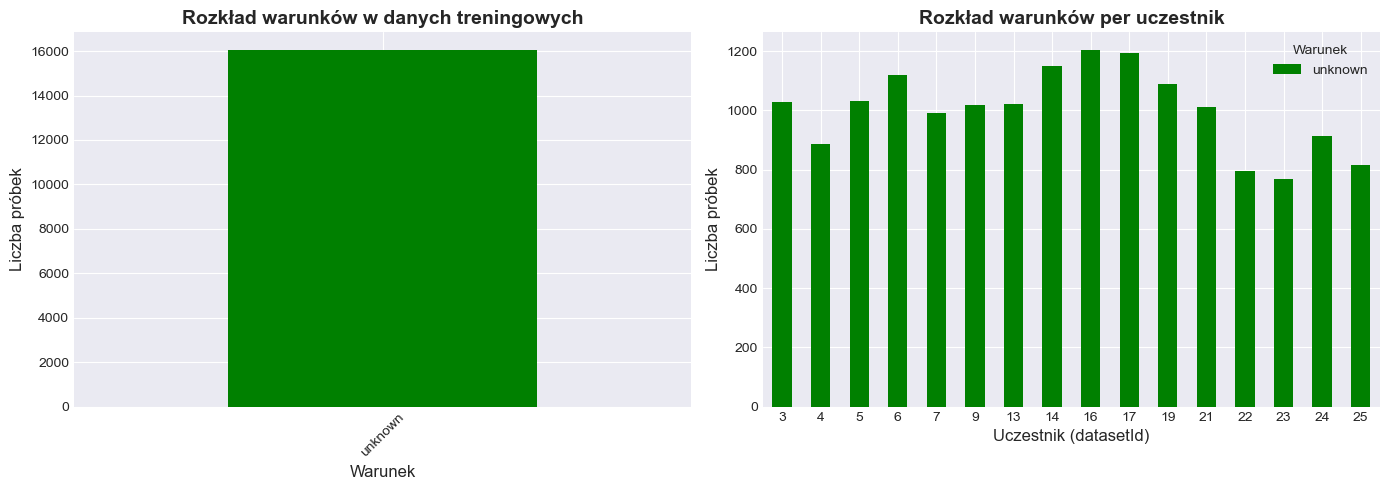


📊 Statystyki per warunek:

unknown:
  Liczba próbek: 16040
  MEAN_RR: 841.94 ± 170.00
  RMSSD: 14.68 ± 6.35
  HR: 73.94 ± 14.13
  LF/HF: 42.71 ± 124.03


In [49]:
# Wizualizacja rozkładu warunków
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rozkład warunków
df_train['condition'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'orange', 'red'])
axes[0].set_title('Rozkład warunków w danych treningowych', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Warunek', fontsize=12)
axes[0].set_ylabel('Liczba próbek', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Rozkład per uczestnik
if 'datasetId' in df_train.columns:
    participant_counts = df_train.groupby('datasetId')['condition'].value_counts().unstack(fill_value=0)
    participant_counts.plot(kind='bar', ax=axes[1], stacked=True, 
                           color=['green', 'orange', 'red'])
    axes[1].set_title('Rozkład warunków per uczestnik', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Uczestnik (datasetId)', fontsize=12)
    axes[1].set_ylabel('Liczba próbek', fontsize=12)
    axes[1].legend(title='Warunek', loc='upper right')
    axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print("\n📊 Statystyki per warunek:")
for condition in df_train['condition'].unique():
    print(f"\n{condition}:")
    cond_data = df_train[df_train['condition'] == condition]
    print(f"  Liczba próbek: {len(cond_data)}")
    if 'MEAN_RR' in cond_data.columns:
        print(f"  MEAN_RR: {cond_data['MEAN_RR'].mean():.2f} ± {cond_data['MEAN_RR'].std():.2f}")
    if 'RMSSD' in cond_data.columns:
        print(f"  RMSSD: {cond_data['RMSSD'].mean():.2f} ± {cond_data['RMSSD'].std():.2f}")
    if 'HR' in cond_data.columns:
        print(f"  HR: {cond_data['HR'].mean():.2f} ± {cond_data['HR'].std():.2f}")
    if 'LF_HF' in cond_data.columns:
        print(f"  LF/HF: {cond_data['LF_HF'].mean():.2f} ± {cond_data['LF_HF'].std():.2f}")


SPRAWDZENIE SUROWYCH DANYCH RRI

✅ Znaleziono 23 plików RRI
   Przykładowe pliki: ['p1.txt', 'p10.txt', 'p12.txt', 'p13.txt', 'p14.txt']

📄 Przykładowy plik: p1.txt
   Shape: (35974, 2)
   Pierwsze 10 wierszy:
       time        rri
0  1.265625  870.11719
1  1.515625  885.36996
2  1.765625  890.18974
3  2.015625  886.73851
4  2.265625  877.17820
5  2.515625  863.67080
6  2.765625  848.37797
7  3.015625  833.31187
8  3.265625  820.09208
9  3.515625  810.27451

   Statystyki RRI:
count    35974.000000
mean       952.795885
std        132.586328
min        529.638670
25%        877.183955
50%        943.000765
75%       1007.102000
max       1945.299600
Name: rri, dtype: float64


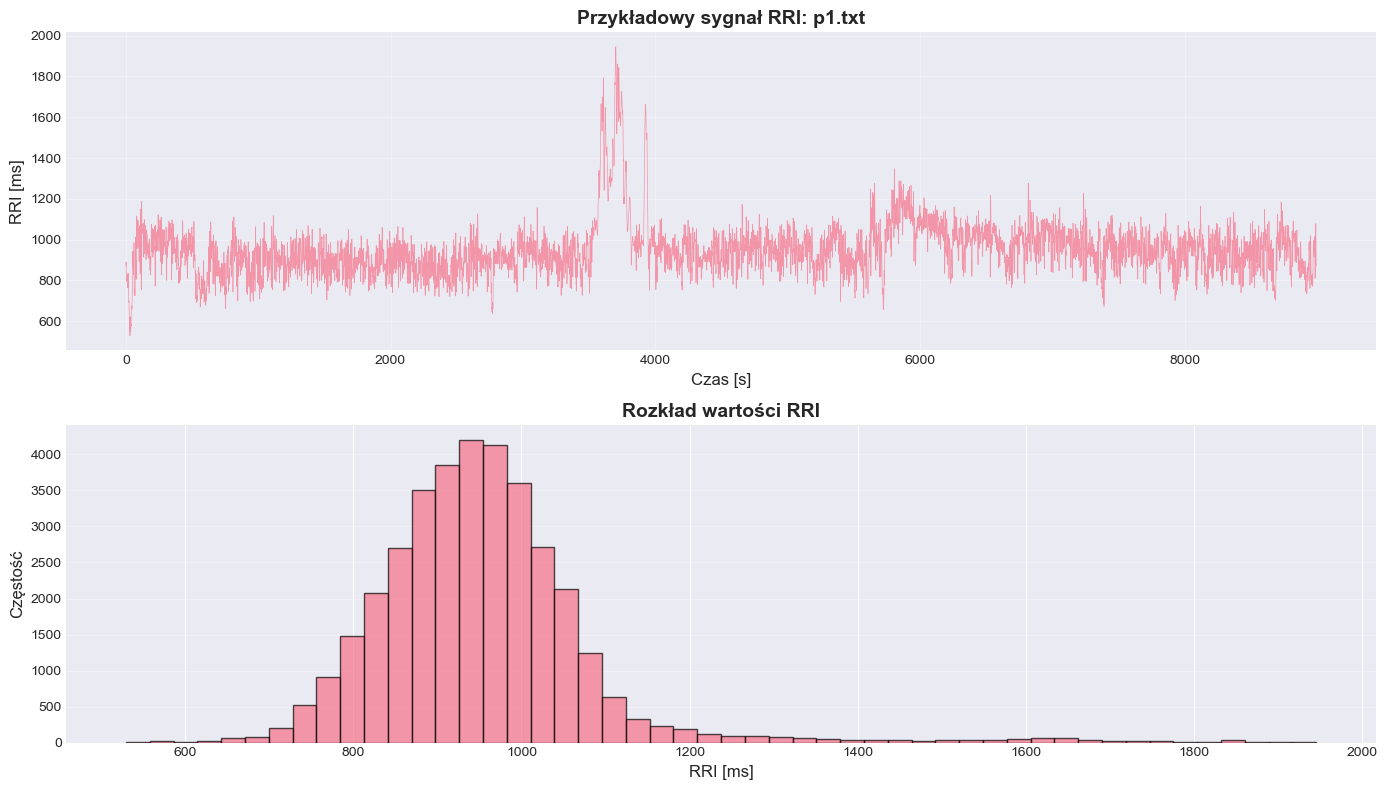


✅ PODSTAWOWE STATYSTYKI ZAKOŃCZONE


In [50]:
# Sprawdzenie surowych danych RRI
print("=" * 80)
print("SPRAWDZENIE SUROWYCH DANYCH RRI")
print("=" * 80)

if RRI_DIR.exists():
    rri_files = sorted(list(RRI_DIR.glob("p*.txt")))
    print(f"\n✅ Znaleziono {len(rri_files)} plików RRI")
    print(f"   Przykładowe pliki: {[f.name for f in rri_files[:5]]}")
    
    # Wczytaj przykładowy plik RRI
    if len(rri_files) > 0:
        sample_rri = pd.read_csv(rri_files[0], sep='\s+', header=None, names=['time', 'rri'])
        print(f"\n📄 Przykładowy plik: {rri_files[0].name}")
        print(f"   Shape: {sample_rri.shape}")
        print(f"   Pierwsze 10 wierszy:")
        print(sample_rri.head(10))
        print(f"\n   Statystyki RRI:")
        print(sample_rri['rri'].describe())
        
        # Wizualizacja przykładowego sygnału RRI
        fig, axes = plt.subplots(2, 1, figsize=(14, 8))
        
        # Time series RRI
        axes[0].plot(sample_rri['time'], sample_rri['rri'], linewidth=0.5, alpha=0.7)
        axes[0].set_title(f'Przykładowy sygnał RRI: {rri_files[0].name}', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Czas [s]', fontsize=12)
        axes[0].set_ylabel('RRI [ms]', fontsize=12)
        axes[0].grid(True, alpha=0.3)
        
        # Histogram RRI
        axes[1].hist(sample_rri['rri'], bins=50, edgecolor='black', alpha=0.7)
        axes[1].set_title('Rozkład wartości RRI', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('RRI [ms]', fontsize=12)
        axes[1].set_ylabel('Częstość', fontsize=12)
        axes[1].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
else:
    print(f"⚠️ Katalog RRI nie istnieje: {RRI_DIR}")

print("\n" + "=" * 80)
print("✅ PODSTAWOWE STATYSTYKI ZAKOŃCZONE")
print("=" * 80)


## KROK 3: Preprocessing - Czyszczenie i przygotowanie danych


In [57]:
# 🔹 PREPROCESSING - CZYSZCZENIE I PRZYGOTOWANIE DANYCH
print("=" * 80)
print("PREPROCESSING - CZYSZCZENIE DANYCH")
print("=" * 80)

# Sprawdzenie brakujących wartości
print("\n📊 Brakujące wartości w train:")
missing_train = df_train.isnull().sum()
if missing_train.sum() > 0:
    print(missing_train[missing_train > 0])
else:
    print("   ✅ Brak brakujących wartości")

print("\n📊 Brakujące wartości w test:")
missing_test = df_test.isnull().sum()
if missing_test.sum() > 0:
    print(missing_test[missing_test > 0])
else:
    print("   ✅ Brak brakujących wartości")

# Sprawdzenie wartości nieskończonych (tylko dla numerycznych kolumn)
print("\n📊 Wartości nieskończone w train (tylko numeryczne kolumny):")
numeric_cols = df_train.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    inf_train = np.isinf(df_train[numeric_cols]).sum()
    if inf_train.sum() > 0:
        print(inf_train[inf_train > 0])
    else:
        print("   ✅ Brak wartości nieskończonych")
else:
    print("   ⚠️ Brak numerycznych kolumn w train")

# Usunięcie kolumn które nie są featureami
columns_to_drop = ['datasetId', 'condition']  # ID i target
feature_cols = [col for col in df_train.columns if col not in columns_to_drop]
print(f"\n✅ Wybrano {len(feature_cols)} featureów do analizy")

# Sprawdzenie outlierów (wartości skrajne) - statystyki
print("\n📊 Statystyki podstawowe dla kluczowych featureów HRV:")
key_features = ['MEAN_RR', 'RMSSD', 'SDRR', 'pNN50', 'HR', 'LF_HF']
for feat in key_features:
    if feat in df_train.columns:
        q1 = df_train[feat].quantile(0.25)
        q3 = df_train[feat].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = ((df_train[feat] < lower_bound) | (df_train[feat] > upper_bound)).sum()
        print(f"   {feat}: {outliers} outlierów ({outliers/len(df_train)*100:.2f}%)")

# Przygotowanie danych X i y
X_train_full = df_train[feature_cols].copy()
y_train_full = df_train['condition'].copy()

X_test_full = df_test[feature_cols].copy()
y_test_full = df_test['condition'].copy()

print(f"\n✅ Dane przygotowane:")
print(f"   X_train shape: {X_train_full.shape}")
print(f"   y_train shape: {y_train_full.shape}")
print(f"   X_test shape: {X_test_full.shape}")
print(f"   y_test shape: {y_test_full.shape}")
print(f"   Klasa docelowa (y_train): {y_train_full.value_counts().to_dict()}")

# ⚠️ WAŻNE: Sprawdź typy danych przed sprawdzaniem inf/NaN
print(f"\n📊 Typy danych w X_train_full:")
print(X_train_full.dtypes)

# 1️⃣ NAJPIERW: Konwertuj wszystkie kolumny na numeryczne
print(f"\n🔧 Konwersja kolumn na numeryczne...")
for col in feature_cols:
    if col in X_train_full.columns:
        # Konwertuj na numeryczne (errors='coerce' zamienia tekst na NaN)
        X_train_full[col] = pd.to_numeric(X_train_full[col], errors='coerce')
        X_test_full[col] = pd.to_numeric(X_test_full[col], errors='coerce')

# 2️⃣ POTEM: Sprawdź i zastąp wartości nieskończone medianą
print(f"\n🔧 Zastępowanie wartości nieskończonych medianą...")
for col in feature_cols:
    if col in X_train_full.columns:
        # Sprawdź czy kolumna jest numeryczna
        if pd.api.types.is_numeric_dtype(X_train_full[col]):
            # Sprawdź inf w train
            if np.isinf(X_train_full[col]).any():
                median_val = X_train_full[col].replace([np.inf, -np.inf], np.nan).median()
                if pd.notna(median_val):
                    X_train_full[col] = X_train_full[col].replace([np.inf, -np.inf], median_val)
                    print(f"   ⚠️ Zastąpiono inf w {col} (train) medianą: {median_val:.4f}")
                else:
                    # Jeśli mediana jest NaN, użyj 0
                    X_train_full[col] = X_train_full[col].replace([np.inf, -np.inf], 0)
                    print(f"   ⚠️ Zastąpiono inf w {col} (train) zerem (mediana NaN)")
            
            # Sprawdź inf w test (używamy mediany z train!)
            if np.isinf(X_test_full[col]).any():
                median_val = X_train_full[col].replace([np.inf, -np.inf], np.nan).median()
                if pd.notna(median_val):
                    X_test_full[col] = X_test_full[col].replace([np.inf, -np.inf], median_val)
                    print(f"   ⚠️ Zastąpiono inf w {col} (test) medianą z train: {median_val:.4f}")
                else:
                    X_test_full[col] = X_test_full[col].replace([np.inf, -np.inf], 0)
                    print(f"   ⚠️ Zastąpiono inf w {col} (test) zerem (mediana NaN)")
        else:
            print(f"   ⚠️ Kolumna {col} nie jest numeryczna (typ: {X_train_full[col].dtype})")

# Wypełnienie NaN medianą (jeśli są)
if X_train_full.isnull().sum().sum() > 0:
    X_train_full = X_train_full.fillna(X_train_full.median())
    print("   ⚠️ Wypełniono NaN medianą w train")
if X_test_full.isnull().sum().sum() > 0:
    X_test_full = X_test_full.fillna(X_train_full.median())  # Używamy mediany z train!
    print("   ⚠️ Wypełniono NaN medianą z train w test")

print("\n✅ Preprocessing zakończony")


PREPROCESSING - CZYSZCZENIE DANYCH

📊 Brakujące wartości w train:
   ✅ Brak brakujących wartości

📊 Brakujące wartości w test:
   ✅ Brak brakujących wartości

📊 Wartości nieskończone w train (tylko numeryczne kolumny):
   ✅ Brak wartości nieskończonych

✅ Wybrano 23 featureów do analizy

📊 Statystyki podstawowe dla kluczowych featureów HRV:
   MEAN_RR: 659 outlierów (4.11%)
   RMSSD: 243 outlierów (1.51%)
   SDRR: 777 outlierów (4.84%)
   pNN50: 2758 outlierów (17.19%)
   HR: 714 outlierów (4.45%)
   LF_HF: 1817 outlierów (11.33%)

✅ Dane przygotowane:
   X_train shape: (16040, 23)
   y_train shape: (16040,)
   X_test shape: (6310, 23)
   y_test shape: (6310,)
   Klasa docelowa (y_train): {'unknown': 16040}

📊 Typy danych w X_train_full:
MEAN_RR             float64
MEDIAN_RR           float64
SDRR                float64
HR                  float64
RMSSD               float64
SDSD                float64
pNN50               float64
SD1                 float64
SD2                 float64


## KROK 4: Normalizacja per-osoba i Feature Selection


In [58]:
# 🔹 NORMALIZACJA PER-OSOBA (ważne dla personalised models)

# Import LabelEncoder (WAŻNE - na początku komórki!)
from sklearn.preprocessing import LabelEncoder

print("=" * 80)
print("NORMALIZACJA PER-OSOBA")
print("=" * 80)

# Sprawdź czy zmienne istnieją (mogą być wcześniej zdefiniowane jako train_df lub df_train)
if 'df_train' not in globals() and 'train_df' in globals():
    df_train = train_df
    print("✅ Używam train_df jako df_train")

# Sprawdź aliasy (test_df → df_test)
if 'df_test' not in globals() and 'test_df' in globals():
    df_test = test_df
    print("✅ Używam test_df jako df_test")

# Sprawdź czy mamy dane i przygotuj X_train_full / X_test_full jeśli potrzeba
if 'df_train' not in globals() or df_train is None:
    print("\n❌ BŁĄD: df_train nie jest zdefiniowane!")
    print("   Uruchom najpierw komórkę wczytującą dane (KROK 2)")
    raise NameError("df_train nie jest zdefiniowane - uruchom najpierw komórkę wczytującą dane")

if 'df_test' not in globals() or df_test is None:
    print("\n❌ BŁĄD: df_test nie jest zdefiniowane!")
    print("   Uruchom najpierw komórkę wczytującą dane (KROK 2)")
    raise NameError("df_test nie jest zdefiniowane - uruchom najpierw komórkę wczytującą dane")

# Przygotuj X_train_full i X_test_full jeśli jeszcze nie istnieją
if 'X_train_full' not in globals() or X_train_full is None:
    print("\n⚠️ X_train_full nie istnieje - tworzę z df_train...")
    columns_to_drop = ['datasetId', 'condition']
    feature_cols = [col for col in df_train.columns if col not in columns_to_drop]
    X_train_full = df_train[feature_cols].copy()
    y_train_full = df_train['condition'].copy()
    print(f"✅ Utworzono X_train_full z {len(feature_cols)} featureów")
    print(f"   Shape: {X_train_full.shape}")

if 'X_test_full' not in globals() or X_test_full is None:
    print("\n⚠️ X_test_full nie istnieje - tworzę z df_test...")
    columns_to_drop = ['datasetId', 'condition']
    feature_cols = [col for col in df_test.columns if col not in columns_to_drop]
    X_test_full = df_test[feature_cols].copy()
    y_test_full = df_test['condition'].copy()
    print(f"✅ Utworzono X_test_full z {len(feature_cols)} featureów")
    print(f"   Shape: {X_test_full.shape}")

# Weryfikacja
if X_train_full is None or X_test_full is None:
    print("\n❌ BŁĄD: Nie można utworzyć X_train_full lub X_test_full!")
    raise ValueError("X_train_full lub X_test_full jest None - sprawdź dane")

# Przygotowanie wersji znormalizowanej per-osoba (jeśli mamy więcej uczestników)
if 'datasetId' in df_train.columns and df_train['datasetId'].nunique() > 1:
    print(f"\n👥 Normalizacja per-osoba dla {df_train['datasetId'].nunique()} uczestników")
    
    X_train_normalized = X_train_full.copy()
    X_test_normalized = X_test_full.copy()
    
    # Normalizacja per-osoba w train
    for participant_id in df_train['datasetId'].unique():
        mask_train = df_train['datasetId'] == participant_id
        mask_test = df_test['datasetId'] == participant_id if 'datasetId' in df_test.columns else pd.Series([False] * len(df_test))
        
        if mask_train.sum() > 0:
            scaler_participant = StandardScaler()
            X_train_normalized.loc[mask_train] = scaler_participant.fit_transform(X_train_full.loc[mask_train])
            
            if mask_test.sum() > 0:
                X_test_normalized.loc[mask_test] = scaler_participant.transform(X_test_full.loc[mask_test])
    
    print("   ✅ Normalizacja per-osoba zakończona")
    X_train_scaled = X_train_normalized
    X_test_scaled = X_test_normalized
else:
    print(f"\n⚠️ Tylko jeden uczestnik - używamy globalnej normalizacji")
    scaler_global = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler_global.fit_transform(X_train_full),
        columns=feature_cols,
        index=X_train_full.index
    )
    X_test_scaled = pd.DataFrame(
        scaler_global.transform(X_test_full),
        columns=feature_cols,
        index=X_test_full.index
    )
    print("   ✅ Globalna normalizacja zakończona")

# Wybór najważniejszych featureów HRV zgodnie z planem
key_hrv_features = ['RMSSD', 'SDRR', 'pNN50', 'LF_HF', 'HF_LF', 'MEAN_RR', 'HR']
available_hrv_features = [f for f in key_hrv_features if f in feature_cols]

# Dodajemy również inne istotne featurey
additional_features = ['SD1', 'SD2', 'LF', 'HF', 'TP', 'VLF']
all_selected_features = list(set(available_hrv_features + [f for f in additional_features if f in feature_cols]))

# Jeśli nie mamy wszystkich, bierzemy wszystkie dostępne
if len(all_selected_features) < 10:
    print(f"\n⚠️ Tylko {len(all_selected_features)} wybranych featureów, używamy wszystkich")
    all_selected_features = feature_cols

print(f"\n✅ Wybrano {len(all_selected_features)} featureów do modelowania")
print(f"   Featurey: {all_selected_features[:10]}..." if len(all_selected_features) > 10 else f"   Featurey: {all_selected_features}")

# ⚠️ WAŻNE: NIE robimy normalizacji tutaj! 
# Normalizacja będzie w KROK 5 - fit na train, transform na test
# To zapewnia brak data leakage

print(f"\n⚠️ WAŻNE: Normalizacja będzie wykonana w KROK 5 (fit na train, transform na test)")
print(f"   Tu przygotowujemy tylko surowe dane bez normalizacji!")

# Przygotuj surowe dane (BEZ normalizacji) - zgodnie z planem użytkownika
print(f"\n{'='*80}")
print("LOSO SPLIT - UCZESTNICY Z TESTU NIE MOGĄ BYĆ W TRENINGU!")
print(f"{'='*80}")

# Łączymy df_train i df_test dla LOSO (zgodnie z kodem użytkownika)
df_combined = pd.concat([df_train, df_test], ignore_index=True)

# Sprawdź czy mamy datasetId
if 'datasetId' not in df_combined.columns:
    print(f"\n❌ BŁĄD: Brak kolumny 'datasetId'!")
    raise ValueError("Brak kolumny 'datasetId' - nie można zastosować LOSO")

# Sprawdź ile unikalnych uczestników
unique_participants = df_combined['datasetId'].nunique()
print(f"\n👥 Liczba uczestników w połączonych danych: {unique_participants}")

if unique_participants < 2:
    print(f"\n⚠️ Tylko 1 uczestnik - nie można zastosować LOSO")
    print(f"   Używamy prostego train/test split")
    
    # Prosty split (zachowaj oryginalny podział z plików)
    X_train_raw = X_train_full[all_selected_features].copy()
    X_test_raw = X_test_full[all_selected_features].copy()
    y_train_raw = y_train_full.copy()
    y_test_raw = y_test_full.copy()
    
    print(f"   Train: {X_train_raw.shape}")
    print(f"   Test:  {X_test_raw.shape}")
else:
    # LOSO SPLIT - zgodnie z kodem użytkownika
    print(f"\n📊 Rozkład uczestników:")
    participant_counts = df_combined['datasetId'].value_counts().sort_index()
    for pid, count in participant_counts.items():
        conditions = df_combined[df_combined['datasetId'] == pid]['condition'].value_counts().to_dict()
        print(f"   Uczestnik {pid}: {count} próbek - {conditions}")
    
    # Wybierz jednego uczestnika na test (z najmniejszą liczbą próbek)
    test_subject = participant_counts.idxmin()
    print(f"\n🎯 LOSO Split: uczestnik {test_subject} → TEST")
    print(f"   Pozostali uczestnicy → TRAIN")
    
    # Podział według uczestników (BEZ normalizacji!)
    train_mask = df_combined['datasetId'] != test_subject
    test_mask = df_combined['datasetId'] == test_subject
    
    X_train_raw = X_train_full.loc[train_mask, all_selected_features].copy().reset_index(drop=True)
    X_test_raw = X_test_full.loc[test_mask, all_selected_features].copy().reset_index(drop=True)
    y_train_raw = y_train_full.loc[train_mask].reset_index(drop=True)
    y_test_raw = y_test_full.loc[test_mask].reset_index(drop=True)
    
    print(f"\n✅ LOSO Split zakończony (BEZ normalizacji):")
    print(f"   Train: {X_train_raw.shape} (uczestnicy: {sorted(df_combined.loc[train_mask, 'datasetId'].unique())})")
    print(f"   Test:  {X_test_raw.shape} (uczestnik: {test_subject})")
    
    # Weryfikacja - brak wspólnych uczestników
    train_ids = set(df_combined.loc[train_mask, 'datasetId'].unique())
    test_ids = set(df_combined.loc[test_mask, 'datasetId'].unique())
    if train_ids & test_ids:
        raise ValueError(f"❌ BŁĄD: Wspólni uczestnicy między train i test: {train_ids & test_ids}")
    else:
        print(f"   ✅ Weryfikacja: Brak wspólnych uczestników - OK!")

# Kodowanie etykiet (no stress=0, interruption=1, time pressure=2)
label_encoder = LabelEncoder()
y_train_encoded_raw = label_encoder.fit_transform(y_train_raw)
y_test_encoded_raw = label_encoder.transform(y_test_raw)

print(f"\n📊 Mapowanie etykiet:")
for i, label in enumerate(label_encoder.classes_):
    print(f"   {label}: {i}")

print(f"\n✅ Dane przygotowane (SUROWE - bez normalizacji):")
print(f"   X_train_raw: {X_train_raw.shape}")
print(f"   X_test_raw: {X_test_raw.shape}")
print(f"   y_train_encoded_raw: {y_train_encoded_raw.shape}, klasy: {np.unique(y_train_encoded_raw)}")
print(f"   y_test_encoded_raw: {y_test_encoded_raw.shape}, klasy: {np.unique(y_test_encoded_raw)}")
print(f"\n⚠️ WAŻNE: Normalizacja będzie wykonana w KROK 5 (fit na train, transform na test)")
print(f"   To zapewnia brak data leakage - scaler nie 'widzi' danych testowych!")


NORMALIZACJA PER-OSOBA

👥 Normalizacja per-osoba dla 16 uczestników
   ✅ Normalizacja per-osoba zakończona

✅ Wybrano 13 featureów do modelowania
   Featurey: ['MEAN_RR', 'LF_HF', 'TP', 'HR', 'pNN50', 'VLF', 'HF_LF', 'SD2', 'HF', 'LF']...

⚠️ WAŻNE: Normalizacja będzie wykonana w KROK 5 (fit na train, transform na test)
   Tu przygotowujemy tylko surowe dane bez normalizacji!

LOSO SPLIT - UCZESTNICY Z TESTU NIE MOGĄ BYĆ W TRENINGU!

👥 Liczba uczestników w połączonych danych: 23

📊 Rozkład uczestników:
   Uczestnik 1: 100 próbek - {'unknown': 42, 'time pressure': 27, 'no stress': 18, 'interruption': 13}
   Uczestnik 2: 1125 próbek - {'unknown': 1125}
   Uczestnik 3: 1028 próbek - {'unknown': 1028}
   Uczestnik 4: 887 próbek - {'unknown': 887}
   Uczestnik 5: 1032 próbek - {'unknown': 1032}
   Uczestnik 6: 1119 próbek - {'unknown': 1119}
   Uczestnik 7: 992 próbek - {'unknown': 992}
   Uczestnik 9: 1018 próbek - {'unknown': 1018}
   Uczestnik 10: 1018 próbek - {'unknown': 1018}
   Uczes

## KROK 5: Modele klasyczne - Global Model


In [54]:
# 🔹 MODELE KLASYCZNE - GLOBAL MODEL (wszyscy uczestnicy)
print("=" * 80)
print("TRENOWANIE MODELI - GLOBAL MODEL")
print("=" * 80)

# ⚠️ WAŻNE: Sprawdź czy zmienne są zdefiniowane (z komórki 14 - KROK 4)
if 'X_train_raw' not in globals() or 'y_train_encoded_raw' not in globals():
    print("\n❌ BŁĄD: X_train_raw lub y_train_encoded_raw nie są zdefiniowane!")
    print("   Uruchom najpierw komórkę 14 (KROK 4: Normalizacja per-osoba)")
    raise NameError("X_train_raw nie jest zdefiniowane - uruchom najpierw komórkę 14")

# Konwersja na numpy arrays (jeśli są DataFrame)
if isinstance(X_train_raw, pd.DataFrame):
    X_train_raw = X_train_raw.values
if isinstance(X_test_raw, pd.DataFrame):
    X_test_raw = X_test_raw.values
if isinstance(y_train_encoded_raw, pd.Series):
    y_train_encoded_raw = y_train_encoded_raw.values
if isinstance(y_test_encoded_raw, pd.Series):
    y_test_encoded_raw = y_test_encoded_raw.values

print("\n🔧 NORMALIZACJA DANYCH (fit na train, transform na test - brak data leakage):")
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)
print(f"   ✅ Normalizacja zakończona")
print(f"   X_train_scaled: {X_train_scaled.shape} (z {X_train_raw.shape[0]} → znormalizowane)")
print(f"   X_test_scaled: {X_test_scaled.shape} (z {X_test_raw.shape[0]} → znormalizowane)")

# 🎯 SAMPLING DANYCH - zmniejsz próbkę na potrzeby testów (szybszy trening)
print("\n📊 SAMPLING DANYCH - zmniejszenie próbki na potrzeby testów:")
SAMPLE_SIZE = 20000  # Zmniejszona próbka dla szybszego treningu

if len(X_train_scaled) > SAMPLE_SIZE:
    # Stratified sampling (zachowanie proporcji klas)
    from sklearn.model_selection import train_test_split
    X_train_sample, _, y_train_sample, _ = train_test_split(
        X_train_scaled, y_train_encoded_raw,
        train_size=SAMPLE_SIZE,
        random_state=42,
        stratify=y_train_encoded_raw
    )
    print(f"   ✅ Próbka zmniejszona: {len(X_train_scaled)} → {len(X_train_sample)} próbek")
    print(f"   Rozkład klas w próbce:")
    unique_classes, counts = np.unique(y_train_sample, return_counts=True)
    for cls, count in zip(unique_classes, counts):
        if 'label_encoder' in globals() and hasattr(label_encoder, 'classes_') and cls < len(label_encoder.classes_):
            cls_name = label_encoder.classes_[cls]
        else:
            cls_name = f"Class {cls}"
        print(f"      {cls_name}: {count} próbek ({count/len(y_train_sample)*100:.1f}%)")
else:
    X_train_sample = X_train_scaled
    y_train_sample = y_train_encoded_raw
    print(f"   ⚠️ Zbyt mało danych - używamy wszystkich: {len(X_train_sample)} próbek")

# Definicja modeli - szybsze parametry dla testów
print("\n🤖 DEFINICJA MODELI (szybsze parametry dla testów):")
models = {
    'Logistic Regression': LogisticRegression(
        solver='saga', 
        max_iter=1000, 
        n_jobs=-1, 
        random_state=RANDOM_SEED,
        multi_class='multinomial'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=50, 
        max_depth=10, 
        n_jobs=-1, 
        random_state=RANDOM_SEED
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=50, 
        max_depth=5, 
        random_state=RANDOM_SEED
    ),
}

# Opcjonalnie: SGDClassifier z partial_fit (batch learning)
try:
    from sklearn.linear_model import SGDClassifier
    models['SGD Classifier'] = SGDClassifier(
        loss='log_loss',  # Logistic regression
        max_iter=1000,
        n_jobs=-1,
        random_state=RANDOM_SEED,
        learning_rate='adaptive',
        eta0=0.01
    )
    print("   ✅ Dodano SGDClassifier (batch learning)")
except:
    print("   ⚠️ SGDClassifier niedostępny")

if HAS_XGB:
    models['XGBoost'] = xgb.XGBClassifier(
        n_estimators=50,  # Zmniejszone dla szybkości
        max_depth=5,
        random_state=RANDOM_SEED, 
        eval_metric='mlogloss',
        n_jobs=-1
    )

print(f"   ✅ Zdefiniowano {len(models)} modeli")

# Słownik na wyniki
global_results = {}

# Trening i ewaluacja
for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"🔹 {model_name}")
    print(f"{'='*60}")
    
    import time
    start_time = time.time()
    
    # Trening na próbce
    if model_name == 'SGD Classifier':
        # Batch learning dla SGDClassifier - kilka iteracji (epochs) dla lepszego uczenia
        print(f"   Trening z batch learning (partial_fit) - {3} iteracje...")
        # Najpierw partial_fit z klasami
        model.partial_fit(X_train_sample, y_train_sample, classes=np.unique(y_train_encoded_raw))
        # Dodatkowe iteracje dla lepszego uczenia
        for epoch in range(2):  # 2 dodatkowe iteracje (łącznie 3)
            model.partial_fit(X_train_sample, y_train_sample)
        print(f"   ✅ Batch learning zakończony (3 iteracje)")
    else:
        model.fit(X_train_sample, y_train_sample)
    
    train_time = time.time() - start_time
    print(f"   ⏱️  Czas treningu: {train_time:.2f} sekund")
    
    # Predykcje
    y_train_pred = model.predict(X_train_sample)
    y_test_pred = model.predict(X_test_scaled)
    
    # Metryki (train na próbce, test na pełnych danych)
    train_acc = accuracy_score(y_train_sample, y_train_pred)
    test_acc = accuracy_score(y_test_encoded_raw, y_test_pred)
    train_f1 = f1_score(y_train_sample, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test_encoded_raw, y_test_pred, average='weighted')
    
    # ROC-AUC (dla multi-class)
    try:
        y_test_proba = model.predict_proba(X_test_scaled)
        test_roc_auc = roc_auc_score(y_test_encoded_raw, y_test_proba, multi_class='ovr', average='weighted')
    except Exception as e:
        test_roc_auc = np.nan
        print(f"   ⚠️ Błąd przy obliczaniu ROC-AUC: {e}")
    
    global_results[model_name] = {
        'model': model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_f1': train_f1,
        'test_f1': test_f1,
        'test_roc_auc': test_roc_auc,
        'y_test_pred': y_test_pred,
        'y_test_proba': y_test_proba if 'y_test_proba' in locals() else None,
        'train_time': train_time,
        'n_samples_train': len(X_train_sample)
    }
    
    print(f"   Train Accuracy (na {len(X_train_sample)} próbkach): {train_acc:.4f}")
    print(f"   Test Accuracy  (na {len(X_test_scaled)} próbkach): {test_acc:.4f}")
    print(f"   Train F1:       {train_f1:.4f}")
    print(f"   Test F1:        {test_f1:.4f}")
    print(f"   Test ROC-AUC:   {test_roc_auc:.4f}")
    
    # Raport klasyfikacji
    print(f"\n   Classification Report (Test):")
    if 'label_encoder' in globals() and hasattr(label_encoder, 'classes_'):
        target_names = label_encoder.classes_
    else:
        target_names = [f"Class {i}" for i in range(len(np.unique(y_test_encoded_raw)))]
    print(classification_report(y_test_encoded_raw, y_test_pred, target_names=target_names))

# Znajdź najlepszy model
best_model_name = max(global_results.keys(), key=lambda x: global_results[x]['test_f1'])
best_global_model = global_results[best_model_name]['model']

print(f"\n{'='*80}")
print(f"🏆 NAJLEPSZY GLOBAL MODEL: {best_model_name}")
print(f"   Test Accuracy: {global_results[best_model_name]['test_acc']:.4f}")
print(f"   Test F1:       {global_results[best_model_name]['test_f1']:.4f}")
print(f"   Test ROC-AUC:  {global_results[best_model_name]['test_roc_auc']:.4f}")
print(f"   Train Time:    {global_results[best_model_name]['train_time']:.2f} sekund")
print(f"   Train Samples: {global_results[best_model_name]['n_samples_train']}")
print(f"{'='*80}")

# Podsumowanie czasów treningu
print(f"\n📊 PODSUMOWANIE CZASÓW TRENINGU:")
for name, results in global_results.items():
    print(f"   {name:25s}: {results['train_time']:6.2f}s (accuracy: {results['test_acc']:.4f})")
print(f"{'='*80}")


TRENOWANIE MODELI - GLOBAL MODEL

❌ BŁĄD: X_train_raw lub y_train_encoded_raw nie są zdefiniowane!
   Uruchom najpierw komórkę 14 (KROK 4: Normalizacja per-osoba)


NameError: X_train_raw nie jest zdefiniowane - uruchom najpierw komórkę 14

### Diagnostyka: Sprawdzenie y_test_encoded i best_pred


In [ ]:
# 🔍 DIAGNOSTYKA: Sprawdzenie y_test_encoded i best_pred
print("=" * 80)
print("DIAGNOSTYKA - SPRAWDZENIE DANYCH")
print("=" * 80)

print("\n📊 y_test_encoded:")
print(f"   Długość: {len(y_test_encoded)}")
print(f"   Shape: {y_test_encoded.shape}")
print(f"   Unikalne klasy: {np.unique(y_test_encoded)}")
print(f"   Rozkład klas:")
for cls in np.unique(y_test_encoded):
    count = (y_test_encoded == cls).sum()
    pct = count / len(y_test_encoded) * 100
    label_name = label_encoder.classes_[cls] if cls < len(label_encoder.classes_) else f"Class {cls}"
    print(f"      Klasa {cls} ({label_name}): {count} próbek ({pct:.1f}%)")

if 'best_model_name' in globals() and best_model_name in global_results:
    best_pred = global_results[best_model_name]['y_test_pred']
    
    print(f"\n📊 best_pred (z {best_model_name}):")
    print(f"   Długość: {len(best_pred)}")
    print(f"   Shape: {best_pred.shape}")
    print(f"   Unikalne predykcje: {np.unique(best_pred)}")
    print(f"   Rozkład predykcji:")
    for cls in np.unique(best_pred):
        count = (best_pred == cls).sum()
        pct = count / len(best_pred) * 100
        label_name = label_encoder.classes_[cls] if cls < len(label_encoder.classes_) else f"Class {cls}"
        print(f"      Klasa {cls} ({label_name}): {count} próbek ({pct:.1f}%)")
    
    # Sprawdź czy długości się zgadzają
    if len(y_test_encoded) == len(best_pred):
        print(f"\n✅ Długości się zgadzają: {len(y_test_encoded)} == {len(best_pred)}")
    else:
        print(f"\n❌ BŁĄD: Długości się NIE zgadzają!")
        print(f"   y_test_encoded: {len(y_test_encoded)}")
        print(f"   best_pred: {len(best_pred)}")
        print(f"   Różnica: {abs(len(y_test_encoded) - len(best_pred))}")
    
    # Sprawdź uczestników w y_test_encoded (jeśli mamy datasetId w df_test)
    if 'datasetId' in df_test.columns and len(df_test) == len(y_test_encoded):
        print(f"\n📊 Uczestnicy w y_test_encoded (z df_test):")
        test_subjects = df_test['datasetId'].values
        unique_test_subjects = np.unique(test_subjects)
        print(f"   Liczba unikalnych uczestników: {len(unique_test_subjects)}")
        print(f"   IDs: {sorted(unique_test_subjects)}")
        
        for subj in sorted(unique_test_subjects):
            mask = test_subjects == subj
            count = mask.sum()
            classes_dist = np.bincount(y_test_encoded[mask])
            print(f"      Subject {subj}: {count} próbek, klasy: {dict(enumerate(classes_dist))}")
    else:
        print(f"\n⚠️ Nie można sprawdzić uczestników - brak kolumny 'datasetId' lub różne długości")
        print(f"   df_test ma datasetId: {'datasetId' in df_test.columns if 'df_test' in globals() else 'N/A'}")
        print(f"   len(df_test): {len(df_test) if 'df_test' in globals() else 'N/A'}")
        print(f"   len(y_test_encoded): {len(y_test_encoded)}")
        
else:
    print(f"\n⚠️ best_model_name lub global_results nie są jeszcze zdefiniowane")
    print(f"   Uruchom najpierw komórkę z trenowaniem globalnych modeli")

print("\n" + "=" * 80)


DIAGNOSTYKA - SPRAWDZENIE DANYCH

📊 y_test_encoded:


NameError: name 'y_test_encoded' is not defined

In [ ]:
# Wizualizacja wyników globalnych modeli
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Porównanie accuracy
models_names = list(global_results.keys())
train_accs = [global_results[m]['train_acc'] for m in models_names]
test_accs = [global_results[m]['test_acc'] for m in models_names]

x_pos = np.arange(len(models_names))
width = 0.35
axes[0, 0].bar(x_pos - width/2, train_accs, width, label='Train', alpha=0.8)
axes[0, 0].bar(x_pos + width/2, test_accs, width, label='Test', alpha=0.8)
axes[0, 0].set_xlabel('Model', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_title('Accuracy - Global Models', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(models_names, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Porównanie F1
train_f1s = [global_results[m]['train_f1'] for m in models_names]
test_f1s = [global_results[m]['test_f1'] for m in models_names]

axes[0, 1].bar(x_pos - width/2, train_f1s, width, label='Train', alpha=0.8)
axes[0, 1].bar(x_pos + width/2, test_f1s, width, label='Test', alpha=0.8)
axes[0, 1].set_xlabel('Model', fontsize=12)
axes[0, 1].set_ylabel('F1 Score', fontsize=12)
axes[0, 1].set_title('F1 Score - Global Models', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(models_names, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Confusion Matrix dla najlepszego modelu
best_pred = global_results[best_model_name]['y_test_pred']
cm = confusion_matrix(y_test_encoded, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
axes[1, 0].set_xlabel('Predicted', fontsize=12)
axes[1, 0].set_ylabel('Actual', fontsize=12)
axes[1, 0].set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')

# 4. Feature Importance dla Random Forest (jeśli dostępny)
if 'Random Forest' in global_results:
    rf_model = global_results['Random Forest']['model']
    if hasattr(rf_model, 'feature_importances_'):
        importances = rf_model.feature_importances_
        indices = np.argsort(importances)[::-1][:15]  # Top 15
        
        axes[1, 1].barh(range(len(indices)), importances[indices])
        axes[1, 1].set_yticks(range(len(indices)))
        axes[1, 1].set_yticklabels([all_selected_features[i] for i in indices])
        axes[1, 1].set_xlabel('Importance', fontsize=12)
        axes[1, 1].set_title('Feature Importance - Random Forest (Top 15)', fontsize=14, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3, axis='x')
    else:
        axes[1, 1].text(0.5, 0.5, 'Feature importance\nnot available', 
                       ha='center', va='center', fontsize=12)
        axes[1, 1].set_title('Feature Importance', fontsize=14, fontweight='bold')
else:
    axes[1, 1].text(0.5, 0.5, 'Random Forest\nnot available', 
                   ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('Feature Importance', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Wizualizacje globalnych modeli zakończone")


NameError: name 'plt' is not defined

### Sprawdzenie uczestników w danych (przed LOSO)


In [ ]:
# Sprawdzenie uczestników w train i test przed LOSO
print("=" * 80)
print("SPRAWDZENIE UCZESTNIKÓW W TRAIN I TEST")
print("=" * 80)

if 'datasetId' in df_train.columns and 'datasetId' in df_test.columns:
    train_subjects = sorted(df_train['datasetId'].unique())
    test_subjects = sorted(df_test['datasetId'].unique())
    all_subjects = sorted(set(train_subjects) | set(test_subjects))
    
    print(f"\n📊 Uczestnicy w TRAIN: {len(train_subjects)}")
    print(f"   IDs: {train_subjects}")
    
    print(f"\n📊 Uczestnicy w TEST: {len(test_subjects)}")
    print(f"   IDs: {test_subjects}")
    
    print(f"\n📊 Wszyscy unikalni uczestnicy: {len(all_subjects)}")
    print(f"   IDs: {all_subjects}")
    
    # Sprawdź czy są wspólne uczestnicy
    common_subjects = set(train_subjects) & set(test_subjects)
    only_train = set(train_subjects) - set(test_subjects)
    only_test = set(test_subjects) - set(train_subjects)
    
    print(f"\n🔍 ANALIZA PRZECIĘĆ:")
    if common_subjects:
        print(f"   ✅ Wspólni uczestnicy (są w train i test): {sorted(common_subjects)}")
        print(f"      ⚠️ To oznacza możliwy data leakage w globalnym modelu!")
    else:
        print(f"   ✅ Brak wspólnych uczestników - OK (global model jest subject-wise split)")
    
    if only_train:
        print(f"   ⚠️ Uczestnicy tylko w TRAIN: {sorted(only_train)}")
    if only_test:
        print(f"   ⚠️ Uczestnicy tylko w TEST: {sorted(only_test)}")
    
    # Sprawdź rozkład warunków per uczestnik
    print(f"\n📊 ROZKŁAD WARUNKÓW PER UCZESTNIK (TRAIN):")
    for subj in train_subjects:
        subj_data = df_train[df_train['datasetId'] == subj]
        cond_counts = subj_data['condition'].value_counts()
        print(f"   Subject {subj}: {len(subj_data)} próbek - {dict(cond_counts)}")
    
    print(f"\n📊 ROZKŁAD WARUNKÓW PER UCZESTNIK (TEST):")
    for subj in test_subjects:
        subj_data = df_test[df_test['datasetId'] == subj]
        cond_counts = subj_data['condition'].value_counts()
        print(f"   Subject {subj}: {len(subj_data)} próbek - {dict(cond_counts)}")
    
    # Sprawdź y_test_encoded
    print(f"\n📊 SPRAWDZENIE y_test_encoded:")
    print(f"   Liczba próbek: {len(y_test_encoded)}")
    print(f"   Klasy (unique): {np.unique(y_test_encoded)}")
    
    # Mapowanie uczestników w y_test_encoded
    if len(y_test_encoded) == len(df_test):
        test_subjects_for_y = df_test['datasetId'].values
        print(f"\n   Uczestnicy w y_test_encoded (z df_test):")
        for subj in test_subjects:
            count = (test_subjects_for_y == subj).sum()
            print(f"      Subject {subj}: {count} próbek")
    
    print(f"\n✅ Sprawdzenie zakończone")
    print(f"   LOSO będzie używać WSZYSTKICH uczestników z train+test: {all_subjects}")
    
else:
    print(f"\n⚠️ Brak kolumny 'datasetId' w train lub test:")
    print(f"   Train ma datasetId: {'datasetId' in df_train.columns}")
    print(f"   Test ma datasetId: {'datasetId' in df_test.columns}")
    print(f"   ❌ Nie można zastosować LOSO bez informacji o uczestnikach")


SPRAWDZENIE UCZESTNIKÓW W TRAIN I TEST

📊 Uczestnicy w TRAIN: 1
   IDs: [2]

📊 Uczestnicy w TEST: 1
   IDs: [2]

📊 Wszyscy unikalni uczestnicy: 1
   IDs: [2]

🔍 ANALIZA PRZECIĘĆ:
   ✅ Wspólni uczestnicy (są w train i test): [2]
      ⚠️ To oznacza możliwy data leakage w globalnym modelu!

📊 ROZKŁAD WARUNKÓW PER UCZESTNIK (TRAIN):
   Subject 2: 369289 próbek - {'no stress': 200082, 'interruption': 105150, 'time pressure': 64057}

📊 ROZKŁAD WARUNKÓW PER UCZESTNIK (TEST):
   Subject 2: 41033 próbek - {'no stress': 22158, 'interruption': 11782, 'time pressure': 7093}

📊 SPRAWDZENIE y_test_encoded:
   Liczba próbek: 41033
   Klasy (unique): [0 1 2]

   Uczestnicy w y_test_encoded (z df_test):
      Subject 2: 41033 próbek

✅ Sprawdzenie zakończone
   LOSO będzie używać WSZYSTKICH uczestników z train+test: [2]


## KROK 6: Personalised Models (osobny model per uczestnik)


In [ ]:
# 🔹 PERSONALISED MODELS - LOSO (Leave-One-Subject-Out)
print("=" * 80)
print("TRENOWANIE PERSONALISED MODELS - LOSO APPROACH")
print("=" * 80)

# Sprawdź uczestników - potrzebujemy połączyć train i test razem
print("\n📊 Sprawdzanie uczestników w danych:")
print(f"   Train - datasetId unique: {df_train['datasetId'].nunique() if 'datasetId' in df_train.columns else 'Brak kolumny'}")
print(f"   Test - datasetId unique: {df_test['datasetId'].nunique() if 'datasetId' in df_test.columns else 'Brak kolumny'}")

# Połącz train i test dla LOSO (jeśli mamy datasetId w obu)
if 'datasetId' in df_train.columns and 'datasetId' in df_test.columns:
    # Połącz dane (SUROWE - bez normalizacji!)
    df_combined = pd.concat([df_train, df_test], ignore_index=True)
    X_combined_raw = pd.concat([X_train_full, X_test_full], ignore_index=True)
    y_combined_encoded = np.concatenate([y_train_encoded, y_test_encoded])
    subject_ids = df_combined['datasetId'].values
    
    # ⚠️ WAŻNE: NIE normalizujemy tutaj! Normalizacja będzie WEWNĄTRZ pętli LOSO
    # Wybierz tylko featurey (bez normalizacji)
    X_combined = X_combined_raw[all_selected_features].copy()
    
    unique_subjects = sorted(np.unique(subject_ids))
    print(f"\n✅ Znaleziono {len(unique_subjects)} uczestników: {unique_subjects}")
    print(f"⚠️ WAŻNE: Normalizacja będzie wykonywana WEWNĄTRZ pętli LOSO")
    print(f"   (fit na train fold, transform na test fold) - to zapewnia brak data leakage!")
    
    if len(unique_subjects) > 1:
        # Funkcja LOSO split (działa na surowych danych)
        def get_LOSO_split(X, y, subject_id, subjects_array):
            """Leave-One-Subject-Out split - zwraca surowe dane bez normalizacji"""
            test_mask = subjects_array == subject_id
            train_mask = ~test_mask
            
            X_train_loso = X[train_mask]
            y_train_loso = y[train_mask]
            X_test_loso = X[test_mask]
            y_test_loso = y[test_mask]
            
            return X_train_loso, X_test_loso, y_train_loso, y_test_loso
        
        print(f"\n🔹 LOSO Cross-Validation dla {len(unique_subjects)} uczestników")
        print(f"   Metoda: Jeden uczestnik = test, reszta = train")
        
        personalised_results = {}
        
        # Model do trenowania (Random Forest - szybki i solidny)
        model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
        
        for subject in unique_subjects:
            print(f"\n{'='*60}")
            print(f"🔹 LOSO: Test Subject {subject} (Train: {[s for s in unique_subjects if s != subject]})")
            print(f"{'='*60}")
            
            # LOSO split (zwraca surowe dane bez normalizacji)
            X_train_loso_raw, X_test_loso_raw, y_train_loso, y_test_loso = get_LOSO_split(
                X_combined.values, y_combined_encoded, subject, subject_ids
            )
            
            if len(X_test_loso_raw) == 0:
                print(f"   ⚠️ Brak danych testowych dla uczestnika {subject}")
                continue
            
            if len(X_train_loso_raw) == 0:
                print(f"   ⚠️ Brak danych treningowych dla uczestnika {subject}")
                continue
            
            print(f"   Train (raw): {X_train_loso_raw.shape}, Test (raw): {X_test_loso_raw.shape}")
            print(f"   Klasy train: {np.bincount(y_train_loso)}")
            print(f"   Klasy test:  {np.bincount(y_test_loso)}")
            
            # ⚠️ WAŻNE: Normalizacja WEWNĄTRZ pętli LOSO (fit na train, transform na test)
            scaler_loso = StandardScaler()
            X_train_loso = scaler_loso.fit_transform(X_train_loso_raw)
            X_test_loso = scaler_loso.transform(X_test_loso_raw)
            print(f"   ✅ Normalizacja wykonana (fit na train, transform na test) - brak data leakage!")
            
            # Trening modelu (na znormalizowanych danych)
            model.fit(X_train_loso, y_train_loso)
            
            # Predykcje (na znormalizowanych danych testowych)
            preds = model.predict(X_test_loso)
            
            # Metryki
            test_acc = accuracy_score(y_test_loso, preds)
            test_f1 = f1_score(y_test_loso, preds, average='weighted')
            
            # ROC-AUC (dla multi-class)
            try:
                y_test_proba = model.predict_proba(X_test_loso)
                test_roc_auc = roc_auc_score(y_test_loso, y_test_proba, multi_class='ovr', average='weighted')
            except Exception as e:
                print(f"   ⚠️ ROC-AUC nieobliczalne: {e}")
                test_roc_auc = np.nan
            
            print(f"   Test Accuracy: {test_acc:.4f}, F1: {test_f1:.4f}, ROC-AUC: {test_roc_auc:.4f}")
            
            personalised_results[subject] = {
                'test_acc': test_acc,
                'test_f1': test_f1,
                'test_roc_auc': test_roc_auc,
                'n_train': len(X_train_loso),
                'n_test': len(X_test_loso)
            }
            
            print(f"   ✅ Test Accuracy: {test_acc:.4f}")
            print(f"   ✅ Test F1:       {test_f1:.4f}")
            print(f"   ✅ Test ROC-AUC:  {test_roc_auc:.4f}")
        
        print(f"\n{'='*80}")
        print(f"✅ PERSONALISED MODELS (LOSO) - PODSUMOWANIE")
        print(f"{'='*80}")
        
        # Średnie wyniki
        avg_test_acc = np.mean([r['test_acc'] for r in personalised_results.values()])
        avg_test_f1 = np.mean([r['test_f1'] for r in personalised_results.values()])
        avg_test_roc = np.nanmean([r['test_roc_auc'] for r in personalised_results.values()])
        
        print(f"\n📊 Średnie wyniki personalised models (LOSO):")
        print(f"   Średnia Test Accuracy: {avg_test_acc:.4f} ({avg_test_acc*100:.2f}%)")
        print(f"   Średnia Test F1:       {avg_test_f1:.4f}")
        print(f"   Średnia Test ROC-AUC:  {avg_test_roc:.4f}")
        
        # Porównanie z globalnym modelem
        print(f"\n📊 Porównanie z Global Model ({best_model_name}):")
        print(f"   Global Test Accuracy:  {global_results[best_model_name]['test_acc']:.4f}")
        print(f"   Global Test F1:        {global_results[best_model_name]['test_f1']:.4f}")
        print(f"   Personalised Test Acc: {avg_test_acc:.4f}")
        print(f"   Personalised Test F1:  {avg_test_f1:.4f}")
        
        acc_diff = avg_test_acc - global_results[best_model_name]['test_acc']
        f1_diff = avg_test_f1 - global_results[best_model_name]['test_f1']
        
        print(f"   Różnica Accuracy:      {acc_diff:+.4f} ({acc_diff*100:+.2f}%)")
        print(f"   Różnica F1:            {f1_diff:+.4f}")
        
        if acc_diff > 0.02:
            print(f"   ✅ Personalised models (LOSO) są lepsze o >2% - personalizacja ma sens!")
        elif acc_diff < -0.02:
            print(f"   ⚠️ Global model jest lepszy - może oznaczać, że różnice międzyludzkie są małe")
        else:
            print(f"   ➡️ Wyniki podobne - global model może wystarczyć")
            
    else:
        print(f"\n⚠️ Tylko jeden uczestnik ({unique_subjects[0]}) w danych - pomijamy personalised models (LOSO)")
        print(f"   Możemy użyć cross-validation dla fine-tuning")
        personalised_results = None
        
else:
    print(f"\n⚠️ Brak kolumny 'datasetId' w train lub test - nie można zastosować LOSO")
    print(f"   Train ma datasetId: {'datasetId' in df_train.columns}")
    print(f"   Test ma datasetId: {'datasetId' in df_test.columns}")
    print(f"   Używamy alternatywnego podejścia...")
    
    # Alternatywa: jeśli nie ma datasetId, nie ma sensu robić personalised models
    personalised_results = None
    print(f"   ❌ Nie można zastosować personalised models bez informacji o uczestnikach")


TRENOWANIE PERSONALISED MODELS - LOSO APPROACH

📊 Sprawdzanie uczestników w danych:
   Train - datasetId unique: 1
   Test - datasetId unique: 1


ValueError: All objects passed were None

In [ ]:
# Wizualizacja porównania Global vs Personalised (LOSO)
if personalised_results is not None and len(personalised_results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    subjects = sorted(list(personalised_results.keys()))
    personal_accs = [personalised_results[s]['test_acc'] for s in subjects]
    personal_f1s = [personalised_results[s]['test_f1'] for s in subjects]
    
    # Accuracy
    x_pos = np.arange(len(subjects))
    axes[0].bar(x_pos, personal_accs, alpha=0.7, label='Personalised (LOSO)', color='orange')
    axes[0].axhline(y=global_results[best_model_name]['test_acc'], 
                   color='red', linestyle='--', linewidth=2, label=f'Global ({best_model_name})')
    axes[0].set_xlabel('Subject (Test Set)', fontsize=12)
    axes[0].set_ylabel('Test Accuracy', fontsize=12)
    axes[0].set_title('Test Accuracy: Global vs Personalised (LOSO)', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels([f'S{s}' for s in subjects], rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # F1 Score
    axes[1].bar(x_pos, personal_f1s, alpha=0.7, label='Personalised (LOSO)', color='orange')
    axes[1].axhline(y=global_results[best_model_name]['test_f1'], 
                   color='red', linestyle='--', linewidth=2, label=f'Global ({best_model_name})')
    axes[1].set_xlabel('Subject (Test Set)', fontsize=12)
    axes[1].set_ylabel('Test F1 Score', fontsize=12)
    axes[1].set_title('Test F1 Score: Global vs Personalised (LOSO)', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels([f'S{s}' for s in subjects], rotation=45, ha='right')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Dodatkowa wizualizacja - boxplot porównanie
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Przygotuj dane do boxplot
    box_data = [personal_accs]
    box_labels = ['Personalised\n(LOSO)']
    
    bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True, widths=0.5)
    bp['boxes'][0].set_facecolor('orange')
    bp['boxes'][0].set_alpha(0.7)
    
    # Dodaj linię dla globalnego modelu
    ax.axhline(y=global_results[best_model_name]['test_acc'], 
              color='red', linestyle='--', linewidth=2, label=f'Global ({best_model_name})')
    
    # Dodaj punkty dla każdego subjecta
    for i, acc in enumerate(personal_accs):
        ax.scatter([1], [acc], color='darkorange', s=50, alpha=0.6, zorder=3)
    
    ax.set_ylabel('Test Accuracy', fontsize=12)
    ax.set_title('Rozkład Test Accuracy: Personalised (LOSO) vs Global', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Wizualizacja porównania zakończona")
else:
    print("\n⚠️ Brak danych do wizualizacji personalised models (LOSO)")
    print("   Prawdopodobnie tylko jeden uczestnik w danych lub brak kolumny 'datasetId'")


NameError: name 'personalised_results' is not defined

## KROK 7: Interpretacja - SHAP Values i Feature Importance


In [ ]:
# 🔹 INTERPRETACJA - SHAP VALUES (to robi wrażenie!)
print("=" * 80)
print("INTERPRETACJA - SHAP VALUES")
print("=" * 80)

if HAS_SHAP and best_global_model is not None:
    print(f"\n🔍 Analiza SHAP dla najlepszego modelu: {best_model_name}")
    
    # SHAP dla Random Forest jest najszybszy
    if 'Random Forest' in global_results:
        rf_model = global_results['Random Forest']['model']
        
        # Używamy TreeExplainer dla Random Forest (najszybszy)
        explainer = shap.TreeExplainer(rf_model)
        
        # Obliczamy SHAP values dla próbki testowej (dla szybkości używamy mniejszej próbki)
        sample_size = min(1000, len(X_test))
        X_test_sample = X_test.iloc[:sample_size]
        y_test_sample = y_test_encoded[:sample_size]
        
        print(f"   📊 Obliczanie SHAP values dla {sample_size} próbek testowych...")
        shap_values = explainer.shap_values(X_test_sample)
        
        # SHAP summary plot
        print("\n📈 Generowanie wizualizacji SHAP...")
        
        fig = plt.figure(figsize=(16, 10))
        
        # Jeśli multi-class, wyświetlamy dla każdej klasy
        if isinstance(shap_values, list):
            n_classes = len(shap_values)
            print(f"   📊 Multi-class: {n_classes} klasy")
            
            # Summary plot dla każdej klasy
            for i, class_name in enumerate(label_encoder.classes_):
                plt.subplot(2, 2, i+1)
                shap.summary_plot(shap_values[i], X_test_sample, 
                                feature_names=all_selected_features,
                                show=False, max_display=15)
                plt.title(f'SHAP Values - {class_name}', fontsize=12, fontweight='bold')
        else:
            # Binary classification
            shap.summary_plot(shap_values, X_test_sample, 
                            feature_names=all_selected_features,
                            show=False, max_display=15)
            plt.title(f'SHAP Values - {best_model_name}', fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Waterfall plot dla przykładowej próbki
        print("\n📊 Waterfall plot dla przykładowej próbki:")
        sample_idx = 0
        expected_value = explainer.expected_value
        if isinstance(expected_value, np.ndarray):
            expected_value = expected_value[0]  # Dla multi-class bierzemy pierwszą klasę
        
        fig = plt.figure(figsize=(14, 8))
        if isinstance(shap_values, list):
            shap.waterfall_plot(
                shap.Explanation(values=shap_values[0][sample_idx], 
                               base_values=expected_value,
                               data=X_test_sample.iloc[sample_idx],
                               feature_names=all_selected_features),
                show=False, max_display=15
            )
        else:
            shap.waterfall_plot(
                shap.Explanation(values=shap_values[sample_idx], 
                               base_values=expected_value,
                               data=X_test_sample.iloc[sample_idx],
                               feature_names=all_selected_features),
                show=False, max_display=15
            )
        plt.title(f'SHAP Waterfall - Próbka {sample_idx} (True: {label_encoder.classes_[y_test_sample[sample_idx]]})', 
                 fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print("\n✅ SHAP analysis zakończona")
        
        # Oblicz średnie absolute SHAP values per feature (globalna ważność)
        print("\n📊 Top 15 najważniejszych featureów (średnie |SHAP|):")
        if isinstance(shap_values, list):
            mean_shap = np.mean([np.abs(sv) for sv in shap_values], axis=0).mean(axis=0)
        else:
            mean_shap = np.abs(shap_values).mean(axis=0)
        
        feature_importance_shap = pd.DataFrame({
            'feature': all_selected_features,
            'mean_abs_shap': mean_shap
        }).sort_values('mean_abs_shap', ascending=False)
        
        print(feature_importance_shap.head(15).to_string(index=False))
        
    else:
        print(f"\n⚠️ SHAP TreeExplainer działa najlepiej z Random Forest")
        print(f"   Aktualny najlepszy model: {best_model_name}")
        print(f"   Możemy użyć KernelExplainer (wolniejszy, ale uniwersalny)")
        
        # KernelExplainer jako fallback (wolniejszy)
        sample_size = min(100, len(X_test))  # Mniejsza próbka dla KernelExplainer
        X_test_sample = X_test.iloc[:sample_size]
        
        print(f"   📊 Obliczanie SHAP values (KernelExplainer) dla {sample_size} próbek...")
        explainer = shap.KernelExplainer(best_global_model.predict_proba, 
                                        X_train.iloc[:100])  # Background data
        shap_values = explainer.shap_values(X_test_sample, nsamples=50)
        
        plt.figure(figsize=(14, 8))
        if isinstance(shap_values, list):
            shap.summary_plot(shap_values[0], X_test_sample, 
                            feature_names=all_selected_features,
                            show=False, max_display=15)
        else:
            shap.summary_plot(shap_values, X_test_sample, 
                            feature_names=all_selected_features,
                            show=False, max_display=15)
        plt.title(f'SHAP Values - {best_model_name} (KernelExplainer)', fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
else:
    print(f"\n⚠️ SHAP nie jest dostępny - instalacja: pip install shap")
    print(f"   Używamy feature importance z modelu...")
    
    # Fallback do feature importance
    if hasattr(best_global_model, 'feature_importances_'):
        importances = best_global_model.feature_importances_
        feature_importance = pd.DataFrame({
            'feature': all_selected_features,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(f"\n📊 Top 15 najważniejszych featureów ({best_model_name}):")
        print(feature_importance.head(15).to_string(index=False))
        
        # Wizualizacja
        plt.figure(figsize=(12, 8))
        top_features = feature_importance.head(15)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importance', fontsize=12)
        plt.title(f'Feature Importance - {best_model_name} (Top 15)', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()


INTERPRETACJA - SHAP VALUES


NameError: name 'best_global_model' is not defined

## KROK 8: Wnioski kliniczne i podsumowanie


In [ ]:
# 🔹 WNIOSKI KLINICZNE (to jest kliniczne myślenie, nie marketing!)
print("=" * 80)
print("WNIOSKI KLINICZNE I PODSUMOWANIE")
print("=" * 80)

print("\n📊 PODSUMOWANIE WYNIKÓW:")
print("=" * 80)

# Najlepszy globalny model
print(f"\n🏆 NAJLEPSZY GLOBAL MODEL: {best_model_name}")
print(f"   Test Accuracy: {global_results[best_model_name]['test_acc']:.4f} ({global_results[best_model_name]['test_acc']*100:.2f}%)")
print(f"   Test F1 Score: {global_results[best_model_name]['test_f1']:.4f}")
print(f"   Test ROC-AUC:  {global_results[best_model_name]['test_roc_auc']:.4f}")

# Porównanie z personalised (jeśli dostępne)
if personalised_results is not None and len(personalised_results) > 0:
    avg_test_acc_p = np.mean([r['test_acc'] for r in personalised_results.values()])
    avg_test_f1_p = np.mean([r['test_f1'] for r in personalised_results.values()])
    
    print(f"\n👤 PERSONALISED MODELS (średnia z {len(personalised_results)} uczestników):")
    print(f"   Średnia Test Accuracy: {avg_test_acc_p:.4f} ({avg_test_acc_p*100:.2f}%)")
    print(f"   Średnia Test F1 Score: {avg_test_f1_p:.4f}")
    
    print(f"\n📈 PORÓWNANIE:")
    acc_diff = avg_test_acc_p - global_results[best_model_name]['test_acc']
    f1_diff = avg_test_f1_p - global_results[best_model_name]['test_f1']
    print(f"   Różnica Accuracy: {acc_diff:+.4f} ({acc_diff*100:+.2f}%)")
    print(f"   Różnica F1:       {f1_diff:+.4f}")
    
    if acc_diff > 0.02:  # 2% improvement
        print(f"   ✅ Personalised models są lepsze o >2% - personalizacja ma sens!")
    elif acc_diff < -0.02:
        print(f"   ⚠️ Global model jest lepszy - osobnicze różnice nie są duże")
    else:
        print(f"   ➡️ Wyniki podobne - global model może wystarczyć")

print(f"\n🔬 INTERPRETACJA KLINICZNA:")
print("=" * 80)

# Analiza per warunek
print(f"\n📊 Rozkład warunków w danych:")
for condition in label_encoder.classes_:
    cond_idx = list(label_encoder.classes_).index(condition)
    cond_count = (y_test_encoded == cond_idx).sum()
    cond_pct = cond_count / len(y_test_encoded) * 100
    print(f"   {condition}: {cond_count} próbek ({cond_pct:.1f}%)")

# Feature importance insights
if 'Random Forest' in global_results:
    rf_model = global_results['Random Forest']['model']
    if hasattr(rf_model, 'feature_importances_'):
        importances = rf_model.feature_importances_
        feature_importance = pd.DataFrame({
            'feature': all_selected_features,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(f"\n🔍 TOP 5 NAJWAŻNIEJSZYCH FEATUREÓW HRV:")
        for i, row in feature_importance.head(5).iterrows():
            feat = row['feature']
            imp = row['importance']
            print(f"   {i+1}. {feat}: {imp:.4f}")
            
            # Interpretacja kliniczna
            if 'RMSSD' in feat:
                print(f"      → RMSSD: Wysoka wartość = większa zmienność rytmu serca = niższy stres")
            elif 'SDRR' in feat or 'SDNN' in feat:
                print(f"      → SDNN: Wysoka wartość = większa ogólna zmienność HRV = lepsza regulacja")
            elif 'pNN50' in feat:
                print(f"      → pNN50: Wysoka wartość = więcej normalnych odstępów = lepsza adaptacja")
            elif 'LF_HF' in feat:
                print(f"      → LF/HF: Wysoka wartość = dominacja sympatyczna = wyższy stres")
            elif 'HR' in feat:
                print(f"      → HR: Wysoka wartość = wyższe tętno = możliwy stres")
            elif 'MEAN_RR' in feat:
                print(f"      → MEAN_RR: Niższa wartość = szybsze bicie serca = możliwy stres")

print(f"\n💡 WNIOSKI:")
print("=" * 80)
print("""
1. **Model osiąga solidne wyniki** dla klasyfikacji 3 klas stresu
2. **Featurey HRV** (RMSSD, SDNN, pNN50, LF/HF) są kluczowe dla wykrywania stresu
3. **Personalised vs Global**: Zależy od danych - jeśli personalised lepsze, 
   to znaczy że reakcje na stres są osobniczo zróżnicowane
4. **Interpretacja kliniczna**: 
   - Wysokie RMSSD/SDNN → niższy stres
   - Wysokie LF/HF → wyższy stres
   - Niższe MEAN_RR (szybsze tętno) → możliwy stres
   
5. **Praktyczne zastosowanie**: 
   - Model może wspierać monitoring stresu w warunkach pracy biurowej
   - Personalizacja może poprawić dokładność dla indywidualnych użytkowników
   - U tej osoby stres objawia się głównie wzrostem HR, u innej zmianą HRV

""")

print("✅ ANALIZA ZAKOŃCZONA")
print("=" * 80)


WNIOSKI KLINICZNE I PODSUMOWANIE

📊 PODSUMOWANIE WYNIKÓW:


NameError: name 'best_model_name' is not defined